In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit,expit
from math import radians, cos, sin, asin, sqrt
from matplotlib import rc, rcParams
import matplotlib as mp
from scipy.integrate import simps,quad
import scipy.optimize as op
import io
import os
import requests
import scipy.interpolate as ip
import xarray as xr
import pandas as pd

In [2]:
def da(zf,x0,r,d,nm,h=125):
    return nm/d*(-h+(zf+h)*np.exp(x0/r)-d)

def pycno(x,a,r,h=125):
    return -h+a*np.exp(x/r)

def pycno_(zf,x,r,h):
    return -h + (zf+h) * np.exp(x/r)

def find_nearest(array, value):
    if np.all(np.isnan(array)):
        idx = np.nan
    else:
        array = np.asarray(array)
        idx = np.nanargmin((np.abs(array - value)))
    return idx,array[idx]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [3]:
#define matplotlib style
mp.rcParams.update(mp.rcParamsDefault)
plt.style.use('classic')
plt.style.use('.\mpl_styles\\paper.mplstyle')

In [4]:

 
# Definine the domain of interest
minlat = 44
maxlat = 45
minlon = -124
maxlon = -125
 
# Read data from: http://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSrtm30v6.html
url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/srtm30plus_LonPM180.csv?z[('+str(maxlat)+'):1:('+str(minlat)+')][('+str(minlon)+'):1:('+str(maxlon)+')]'
url

'http://coastwatch.pfeg.noaa.gov/erddap/griddap/srtm30plus_LonPM180.csv?z[(45):1:(44)][(-124):1:(-125)]'

In [5]:
type_dict = {'latitude':float,'longitude':float,'topo':float}
r = requests.get(url, timeout=(3.05, 120))
bathymetry = pd.read_csv(io.BytesIO(r.content),header=[0,1],dtype=type_dict).drop(0)

In [6]:
bathymetry

,latitude,longitude,z
,degrees_north,degrees_east,m
1,44.004167,-124.987500,-842
2,44.004167,-124.979167,-757
3,44.004167,-124.970833,-637
4,44.004167,-124.962500,-437
5,44.004167,-124.954167,-282
...,...,...,...
14636,45.004167,-124.029167,-22
14637,45.004167,-124.020833,-7
14638,45.004167,-124.012500,5


In [7]:
lat = find_nearest(bathymetry['latitude'].values,44.66)[1][0]

In [8]:
find_nearest(bathymetry['latitude'].values,44.66)[0]

9558

In [9]:
bathymetry['latitude'].iloc[find_nearest(bathymetry['latitude'].values,44.66)[0]]

degrees_north    44.6625
Name: 9559, dtype: float64

In [10]:
long = bathymetry['longitude'][(bathymetry['latitude'].squeeze()==lat)].squeeze().values
topo = bathymetry['z'][(bathymetry['latitude'].squeeze()==lat)].squeeze().values

In [11]:
long[topo==-2]

array([-124.0625])

In [12]:
haversine(long[0],lat,long[-13],lat) - haversine(long[0],lat,long[topo==-2],lat)

-2.636240627552965

In [13]:
meters = np.nan*np.zeros(len(long))
for i,lo in enumerate(long):
    meters[i] = haversine(long[0],lat,long[i],lat) - haversine(long[0],lat,long[topo==-2],lat)

In [14]:
r=15
pt = pycno(meters,148,r)

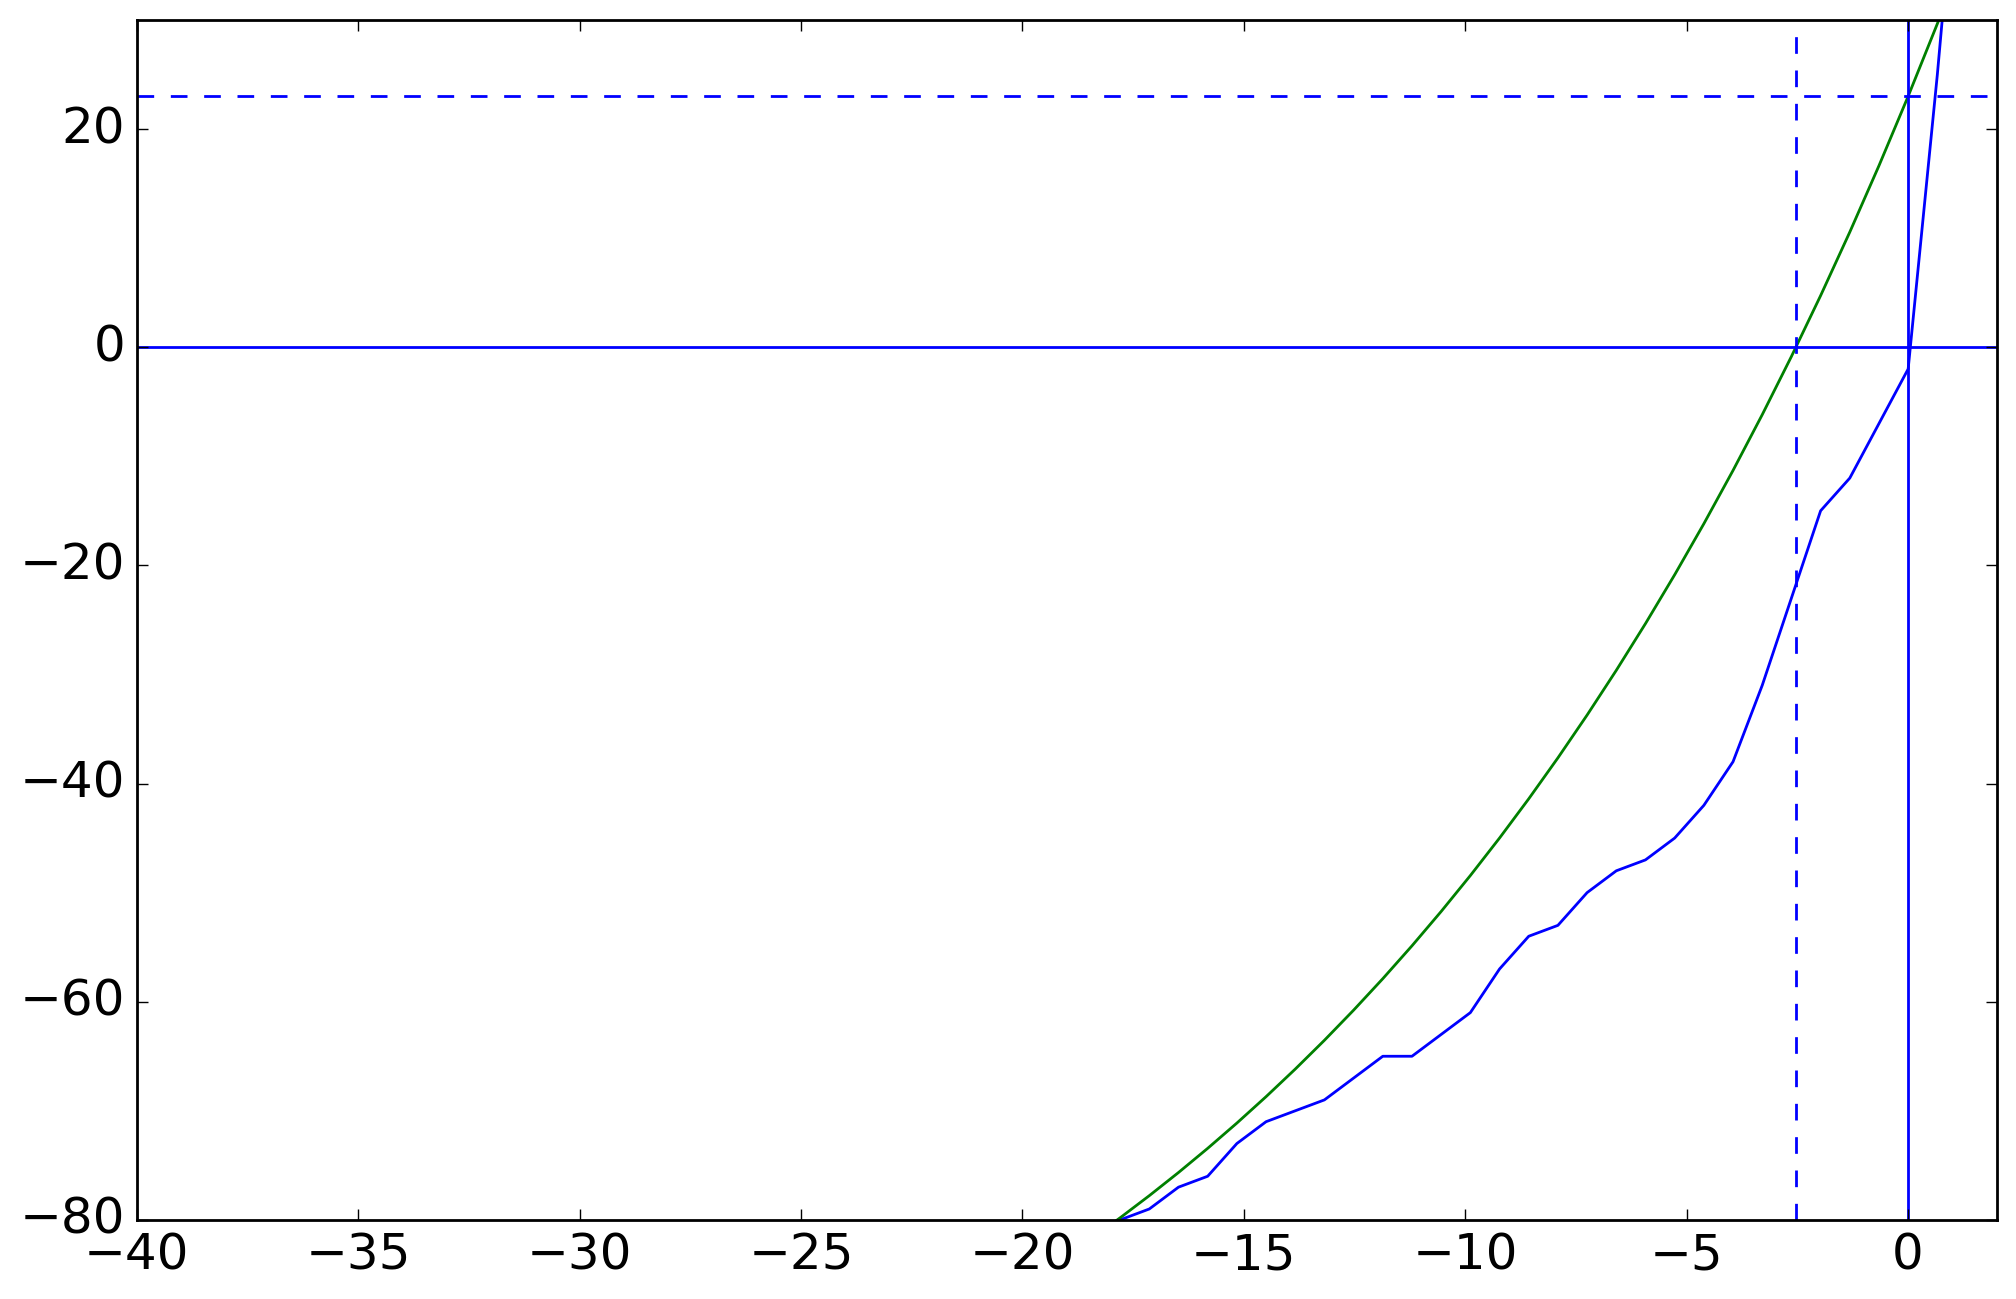

In [15]:
plt.plot(meters,topo)
plt.plot(meters,pt)
plt.xlim([-40,2])
plt.ylim([-80,30])
plt.axvline(r*np.log(125/148),linestyle='--')
plt.axhline(-125+148,linestyle='--')
plt.axhline(0)
plt.axvline(0)

In [16]:
nda = np.nan*np.zeros(len(meters))
for i,(m,p,d) in enumerate(zip(meters,pt,topo)):
    if m < r*np.log(125/148):
        nda[i] = 35/-d*(p-d)
    elif (m > r*np.log(125/148)) & (d < 0):
        nda[i] = 35
    elif d > 0:
        nda[i] = np.nan
    
#plt.plot(long,topo)
#plt.xlim([-124.7,-124])
#plt.ylim([-150,20])
#plt.axvline(r*np.log(125/148),linestyle='--')

In [17]:
plt.figure()
zf = np.arange(-20,30,0.1)
x0 = meters[-13]

<Figure size 2400x1500 with 0 Axes>

In [18]:
zf[112],x0,np.floor(d),r

(-8.79999999999984, -2.636240627552965, 119.0, 15)

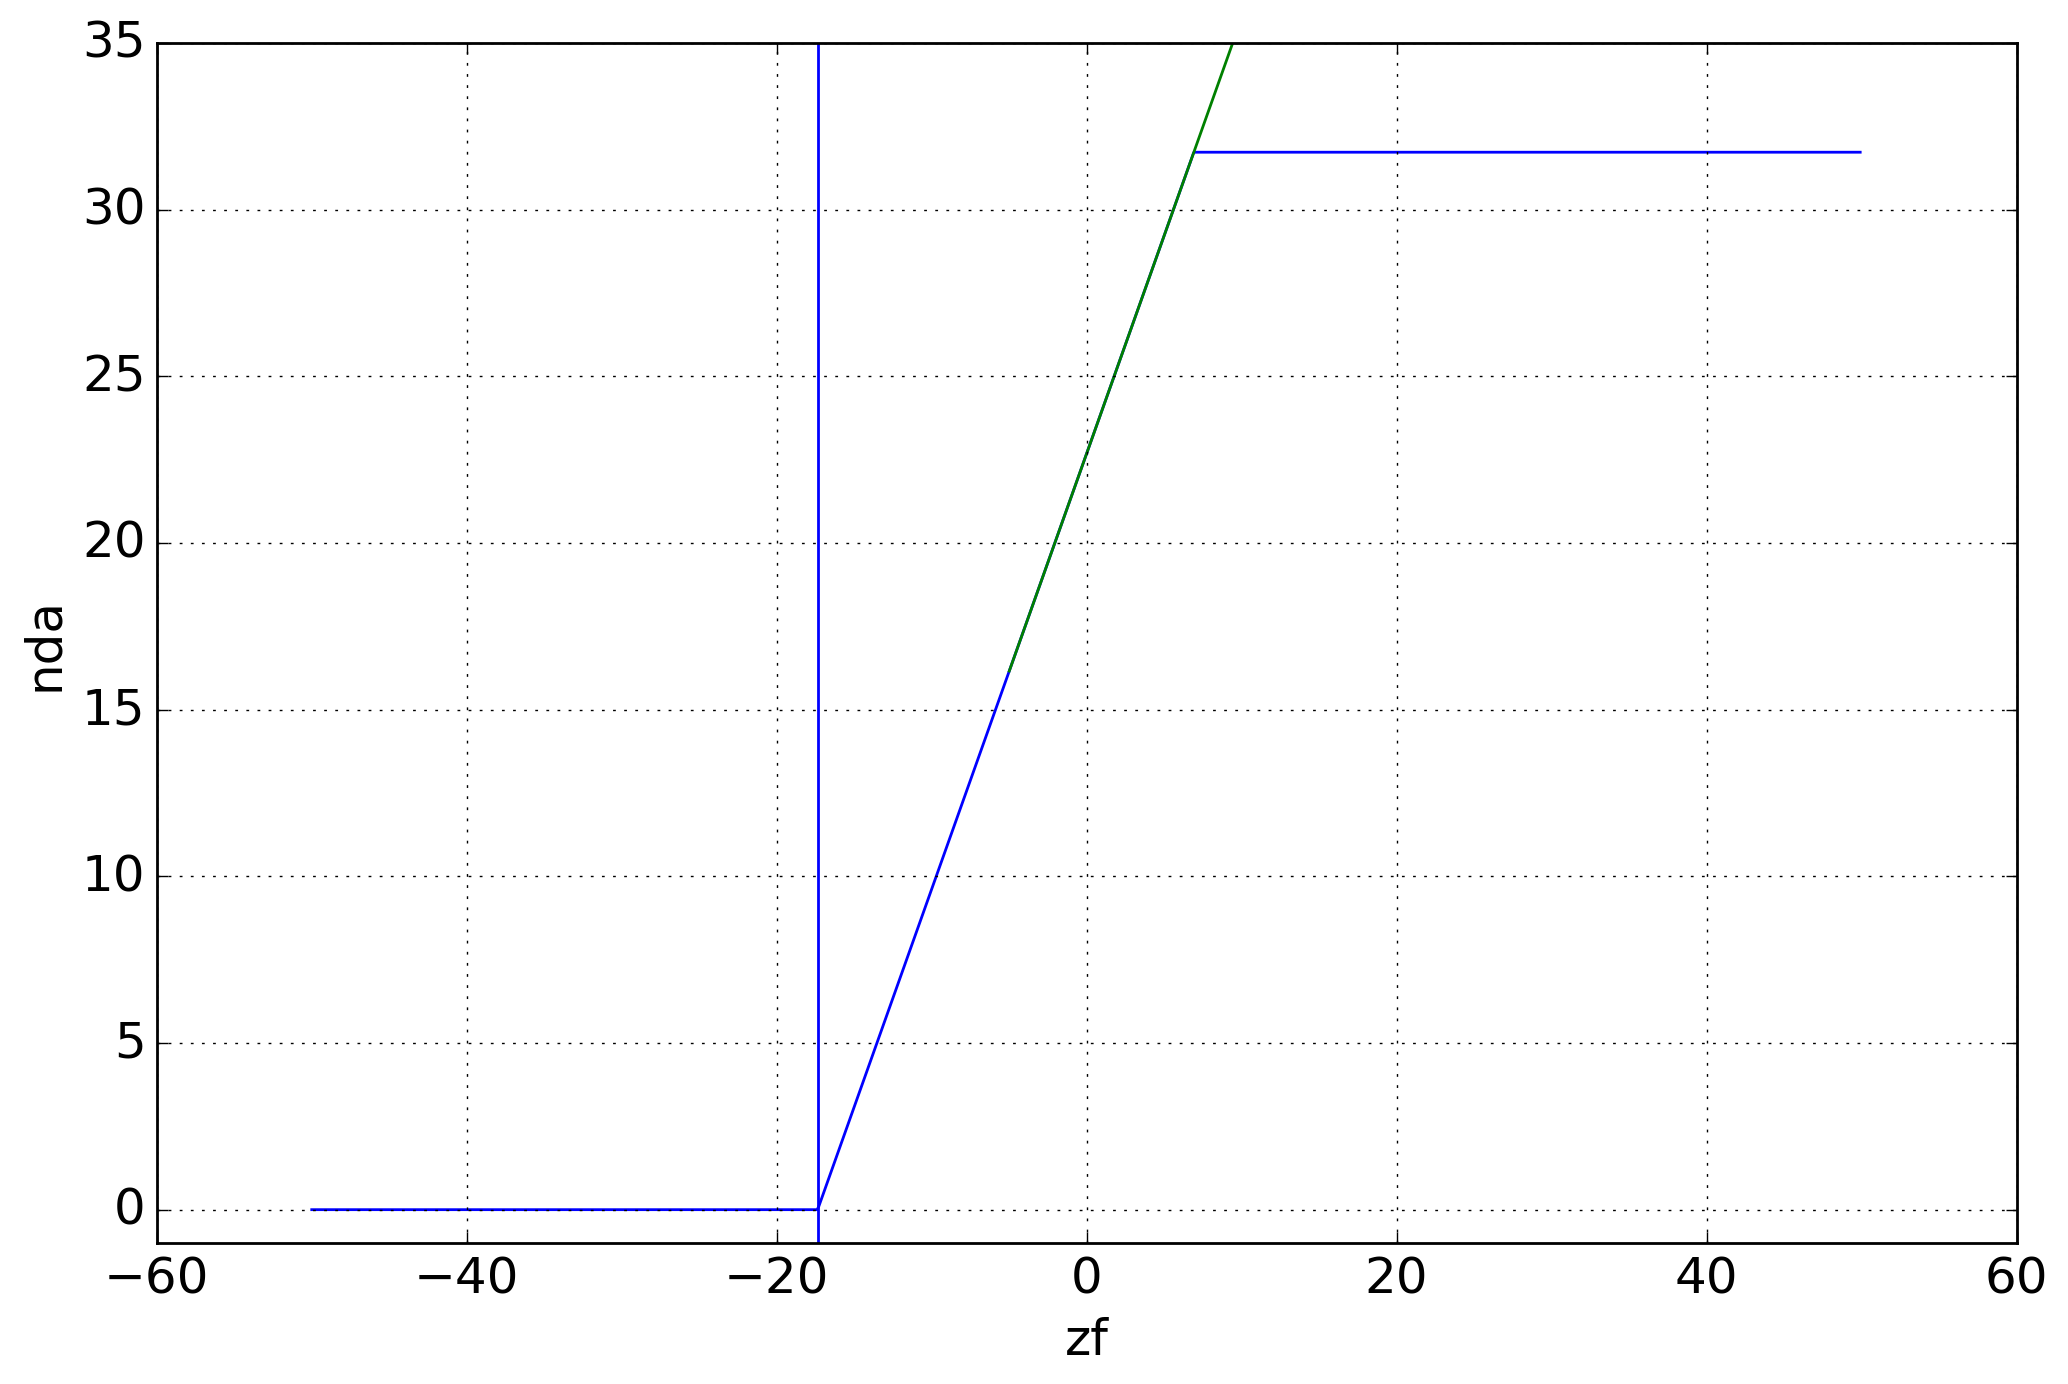

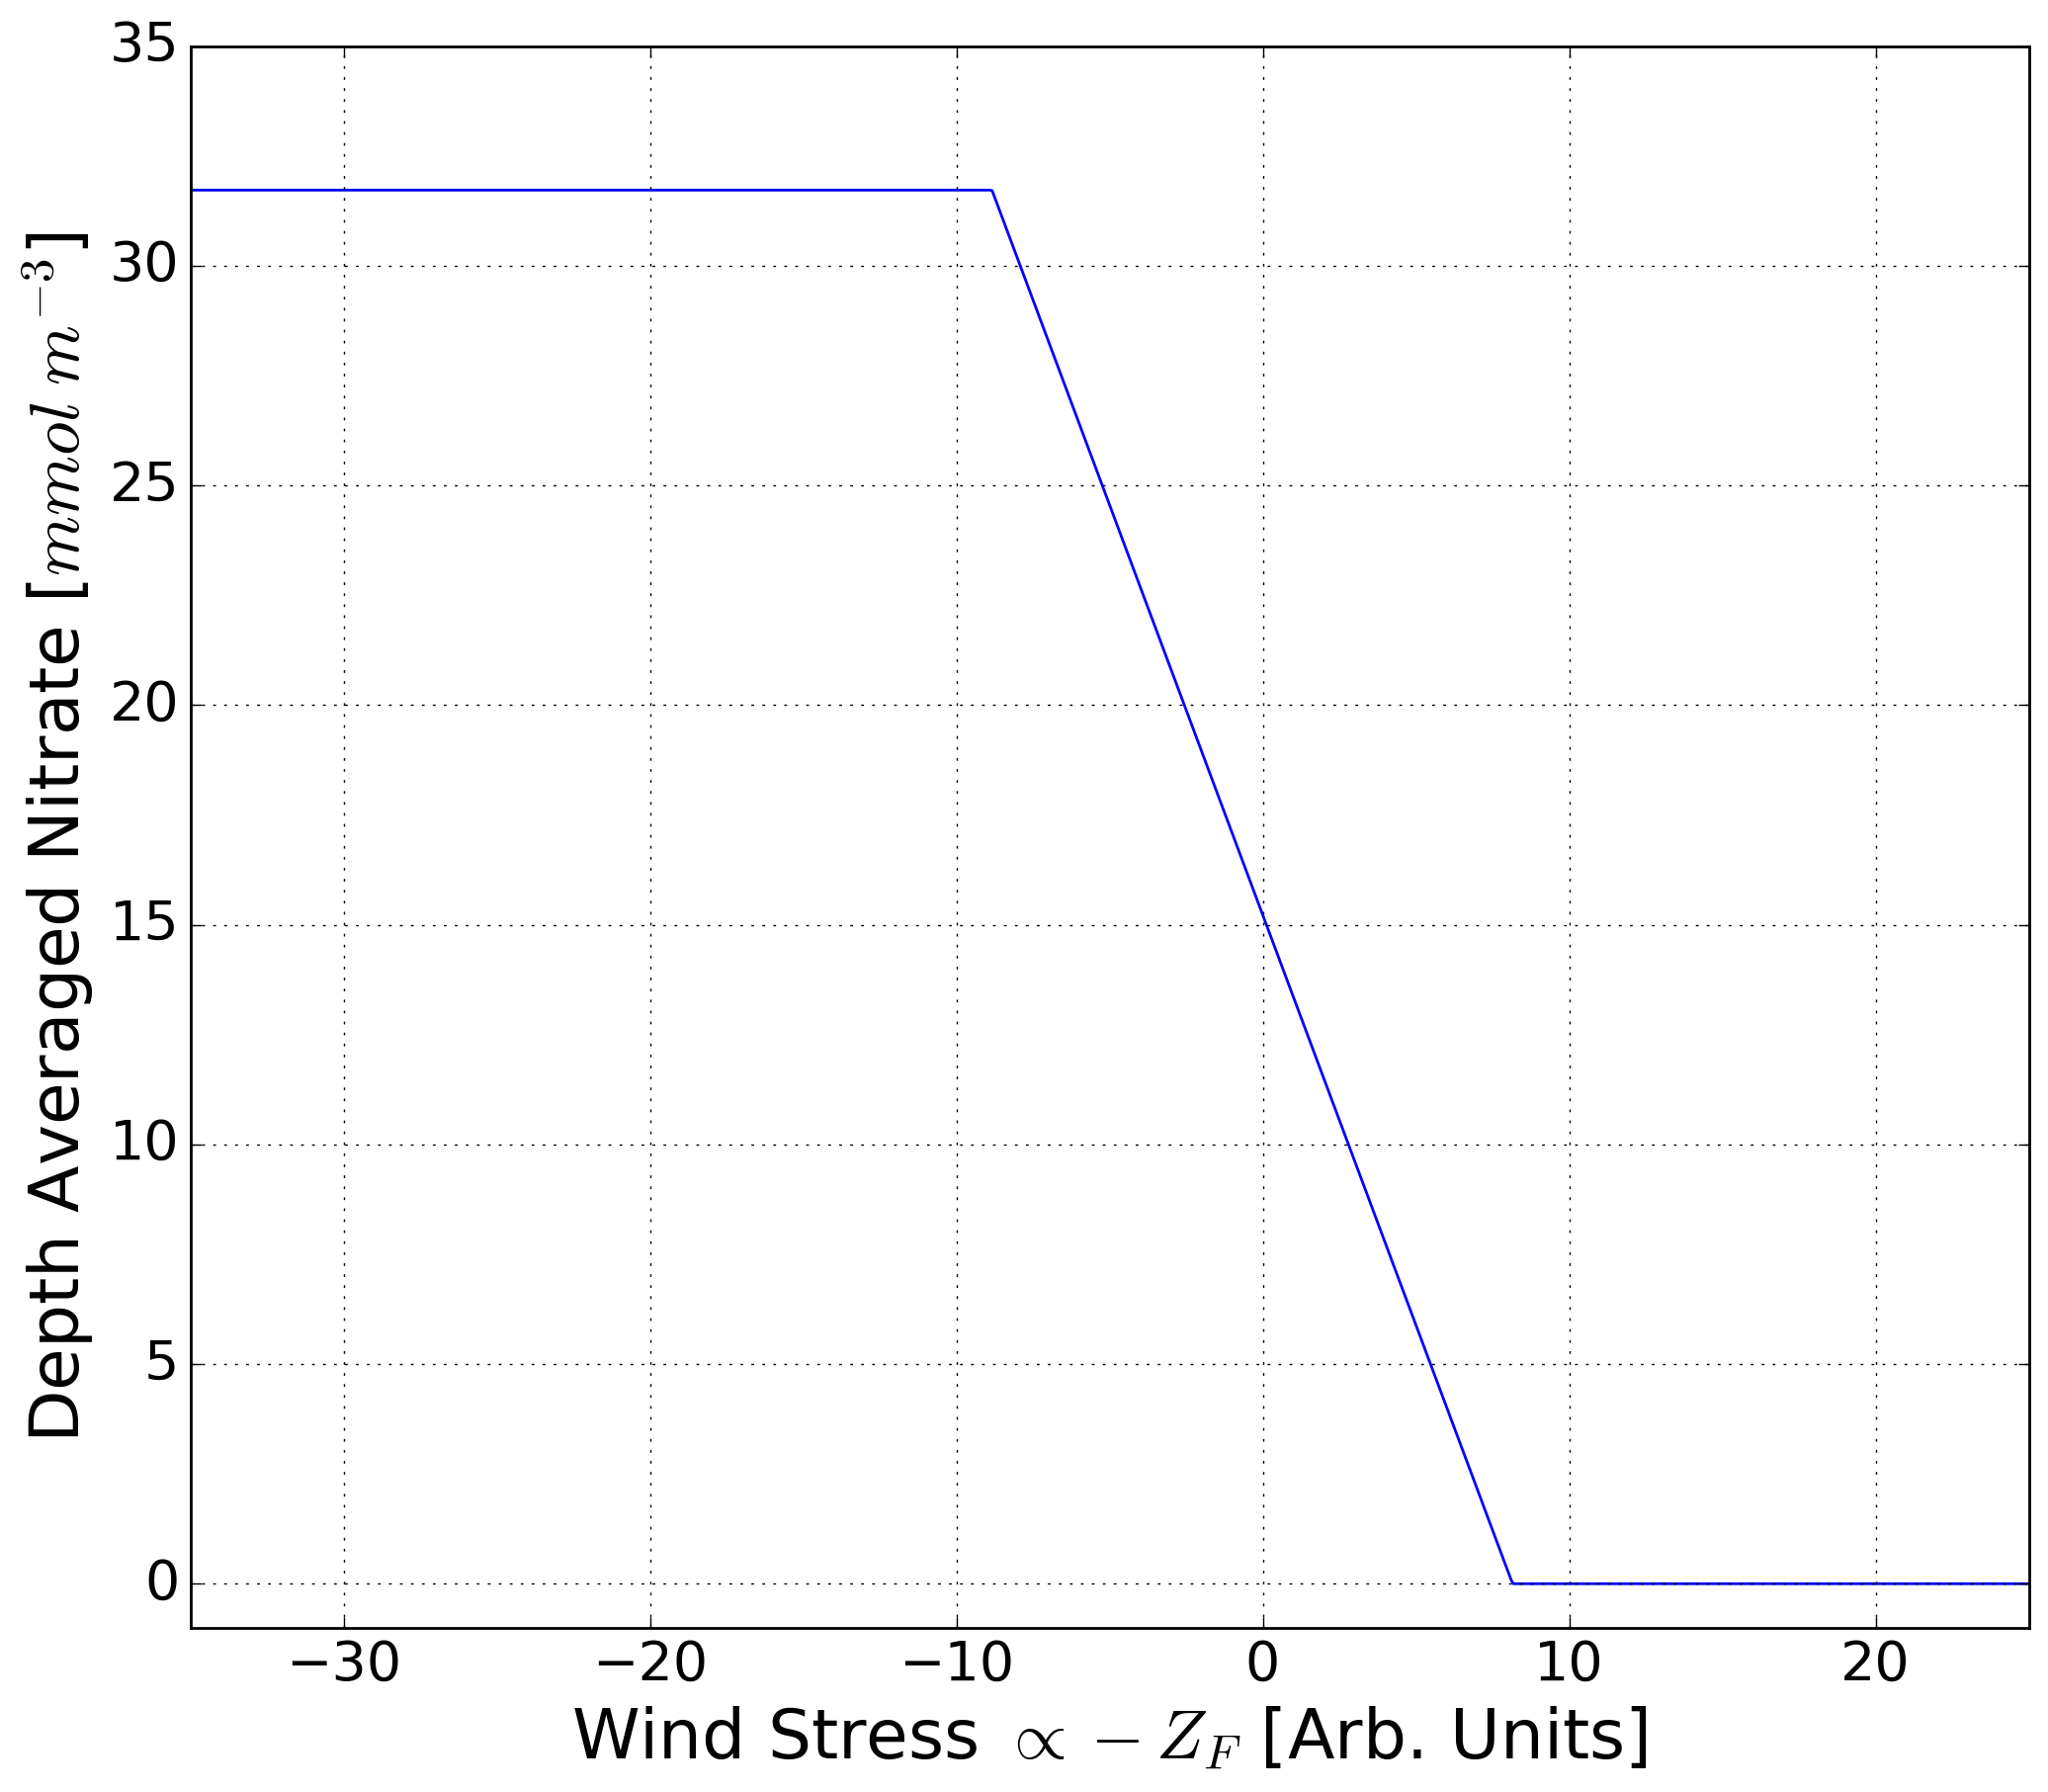

In [19]:
r=49
h=125
N=31.72364566
d = topo[-13]
zf = np.arange(-50,50,0.1)
nda = np.nan*np.zeros(len(zf))
for i,z in enumerate(zf):
    if (0 <= pycno(x0,z+h,r,h)):
        nda[i] = N
    elif (0 > pycno(x0,z+h,r,h)) & (pycno(x0,z+h,r,h) > d):
        nda[i] = -N/d*(pycno(x0,z+h,r,h)-d)
    elif (pycno(x0,z+h,r,h) <= d):
        nda[i] = 0
plt.plot(zf,nda)
plt.xlabel('zf')
plt.ylabel('nda')
plt.grid()
plt.axvline(((d+h)*np.exp(-x0/r)-h))
plt.plot(np.arange(-5,20), (np.arange(-5,20)-((d+h)*np.exp(-x0/r)-h))*-N/d*np.exp(x0/r))
#plt.axvline(-12)
#plt.axvline(8.5)
#plt.xlim([-20,20])
plt.ylim([-1,35])
fig,ax = plt.subplots(figsize=(12,10))
plt.plot(-zf*0.7-4,nda)
plt.xlabel('Wind Stress $\\propto -Z_F$ [Arb. Units]',fontsize=25)
plt.ylabel('Depth Averaged Nitrate [$mmol \; m^{-3}$]',fontsize=25)
plt.grid()
plt.xlim([-35,25])
plt.ylim([-1,35])
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.axvline(-((d+h)*np.exp(-x0/r)-h)*alpha-4)
#plt.plot(np.arange(-18,0), (np.arange(-18,0)+4)*N/d*np.exp(x0/r)/alpha+((d+h)*np.exp(-x0/r)-h)*N/d*np.exp(x0/r))#-31.72364566/d*(h*np.exp(x0/r)-d+h))
#plt.plot(np.arange(-18,0), np.arange(-18,0)*31/d*np.exp(x0/r)+4)
#plt.savefig('figures\\nitr_model.jpg')

In [20]:
alpha = 0.7
slope = 31/d*np.exp(x0/r)/alpha
R = x0/np.log(slope*alpha*d/31)
R,x0,d,slope,((d+h)*np.exp(-x0/r)-h)*N/d*np.exp(x0/r)

(48.99999999999999,
 -2.636240627552965,
 -23,
 -1.8246115286470073,
 22.69289375456037)

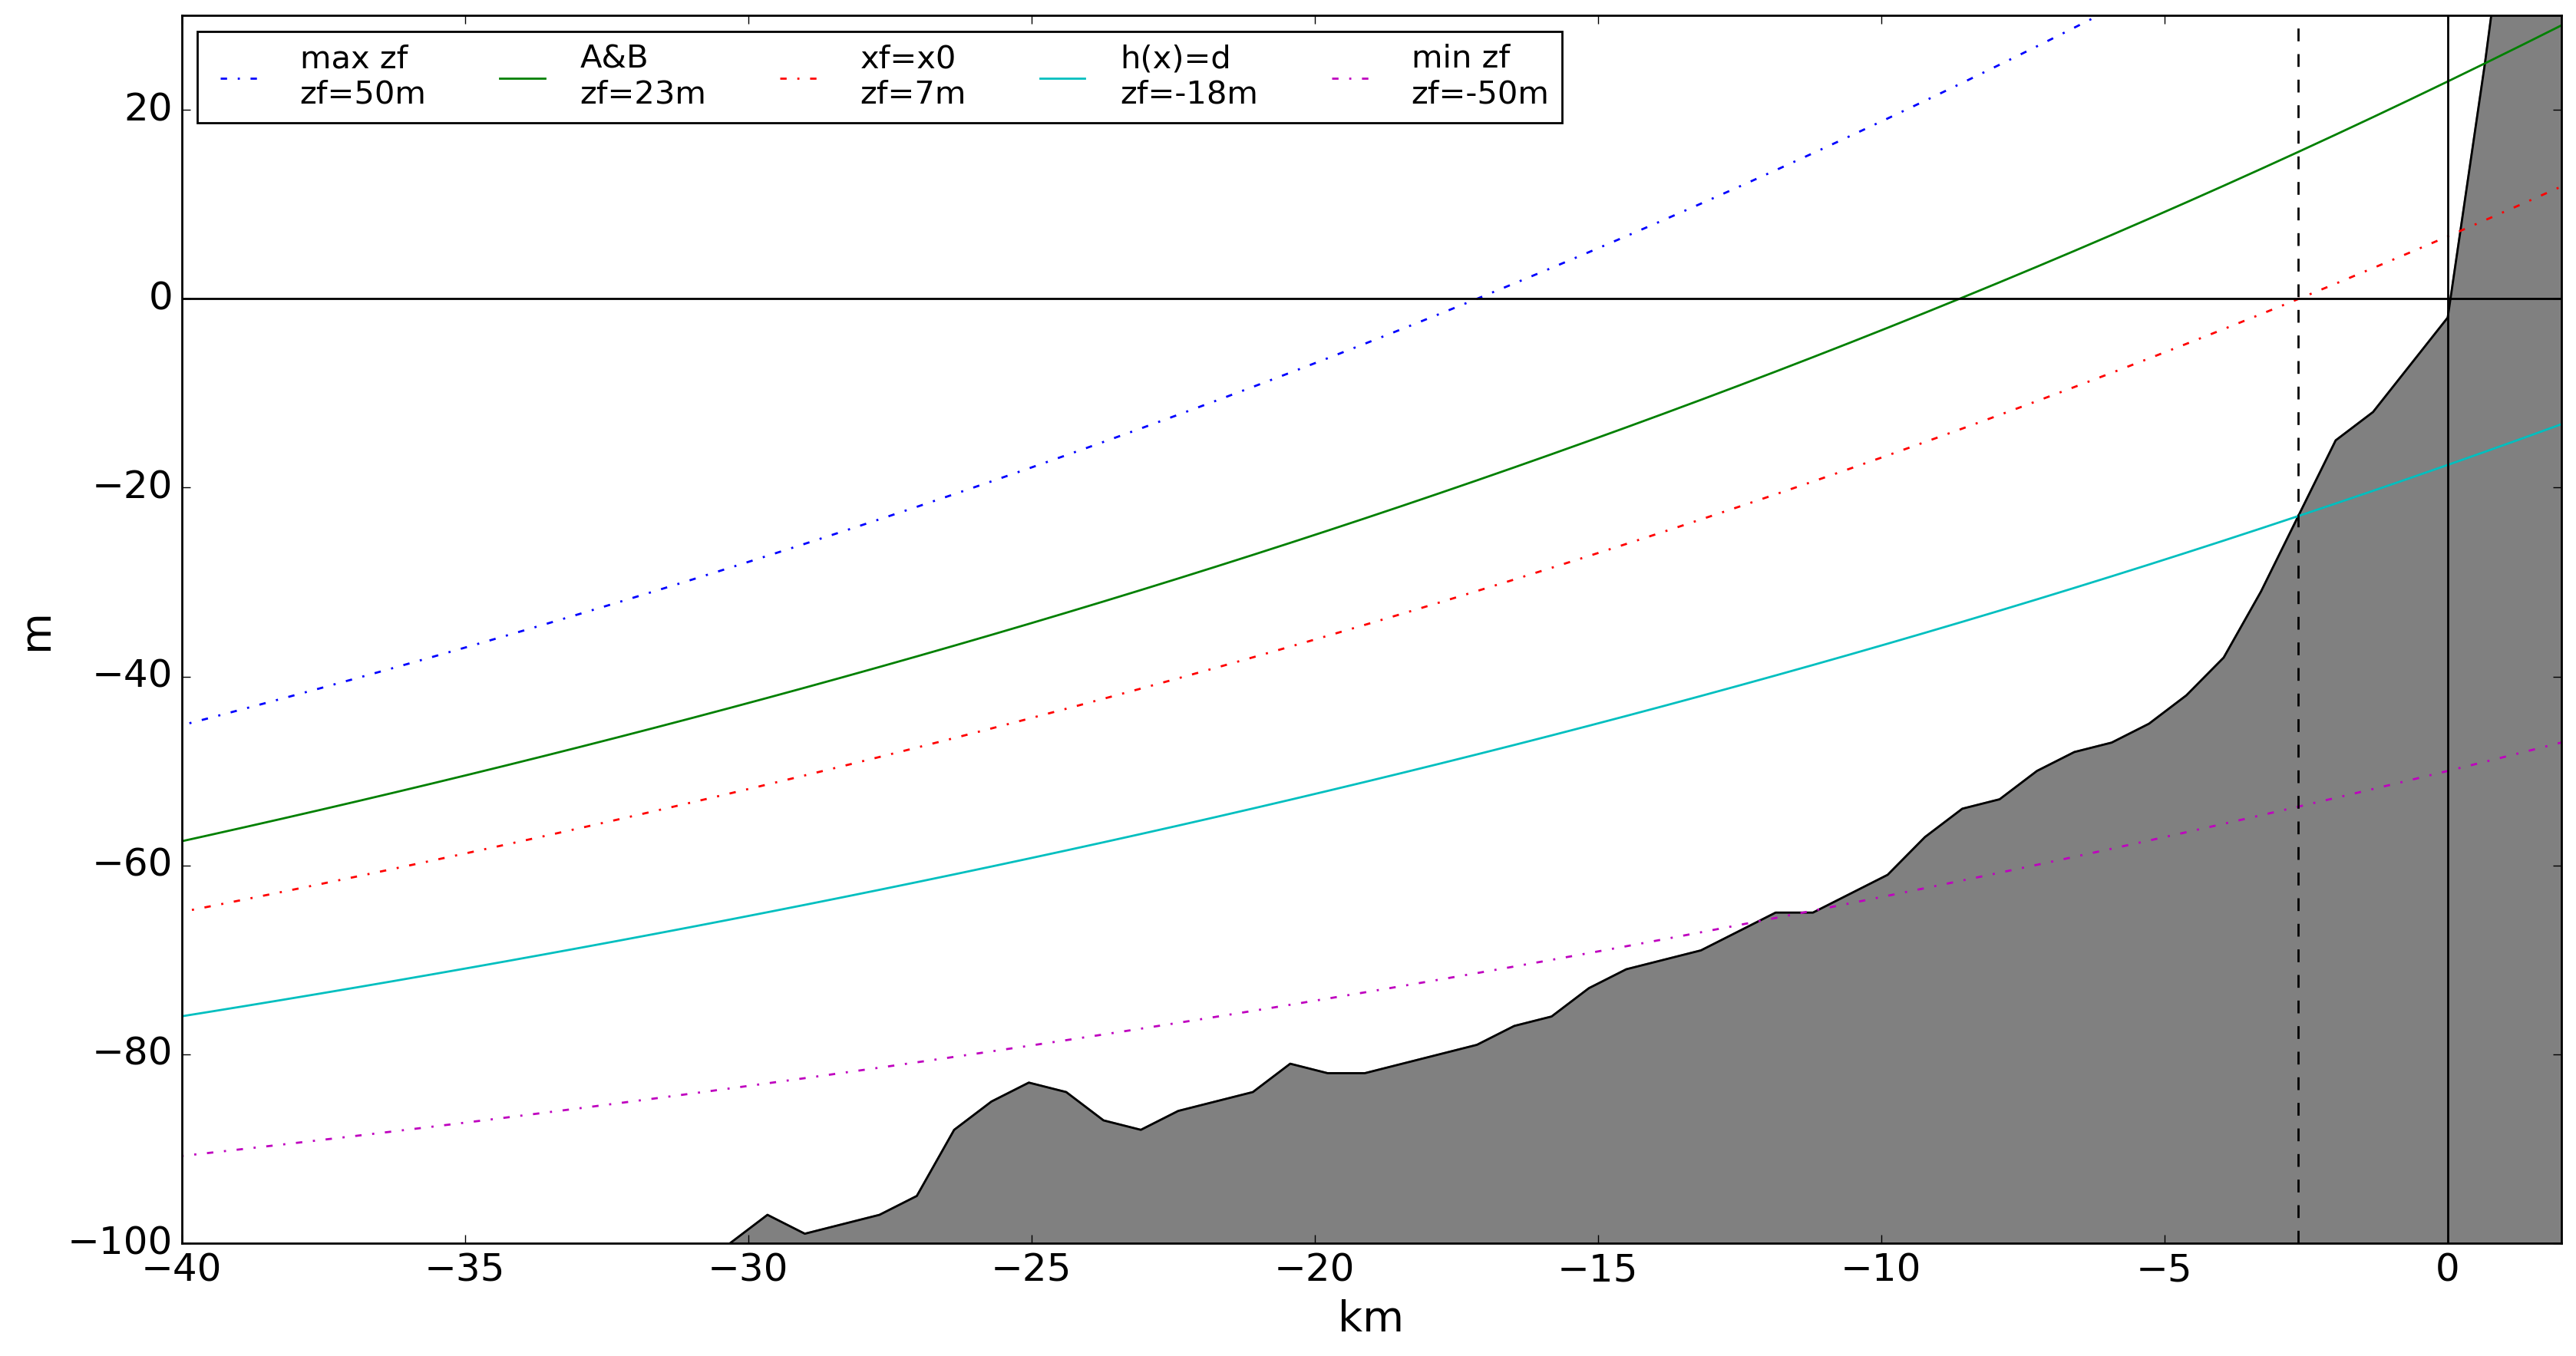

In [21]:
r=51
plt.figure(figsize=(20,10))
plt.plot(meters,topo,color='black')
plt.xlim([-40,2])
plt.ylim([-100,30])
plt.plot(meters,pycno(meters,125+zf[-1],r), '-.', label='max zf\nzf=%.fm'%(zf[-1]))
plt.plot(meters,pycno(meters,125+23,51),label='A&B\nzf=%.fm'%(23))
plt.plot(meters,pycno(meters,125+zf[find_nearest(r*np.log(1-zf/(125+zf)),x0)[0]],r),
         '-.',label='xf=x0\nzf=%.fm'%(zf[find_nearest(r*np.log(1-zf/(125+zf)),x0)[0]]))
plt.plot(meters,pycno(meters,125+zf[find_nearest(pycno(x0,zf+125,r),d)[0]],r),
         label='h(x)=d\nzf=%.fm'%(zf[find_nearest(pycno(x0,zf+125,r),d)[0]]))
plt.plot(meters,pycno(meters,125+zf[0],r),'-.',label='min zf\nzf=%.fm'%(zf[0]))
plt.axhline(0,color='black')
plt.fill_between(meters,-500,topo,color='grey')
plt.axvline(0,color='black')
plt.axvline(x0,color='black',linestyle='--')
plt.xlabel('km',fontsize=20)
plt.ylabel('m',fontsize=20)
plt.legend(ncol=5,loc=2,fontsize=15)

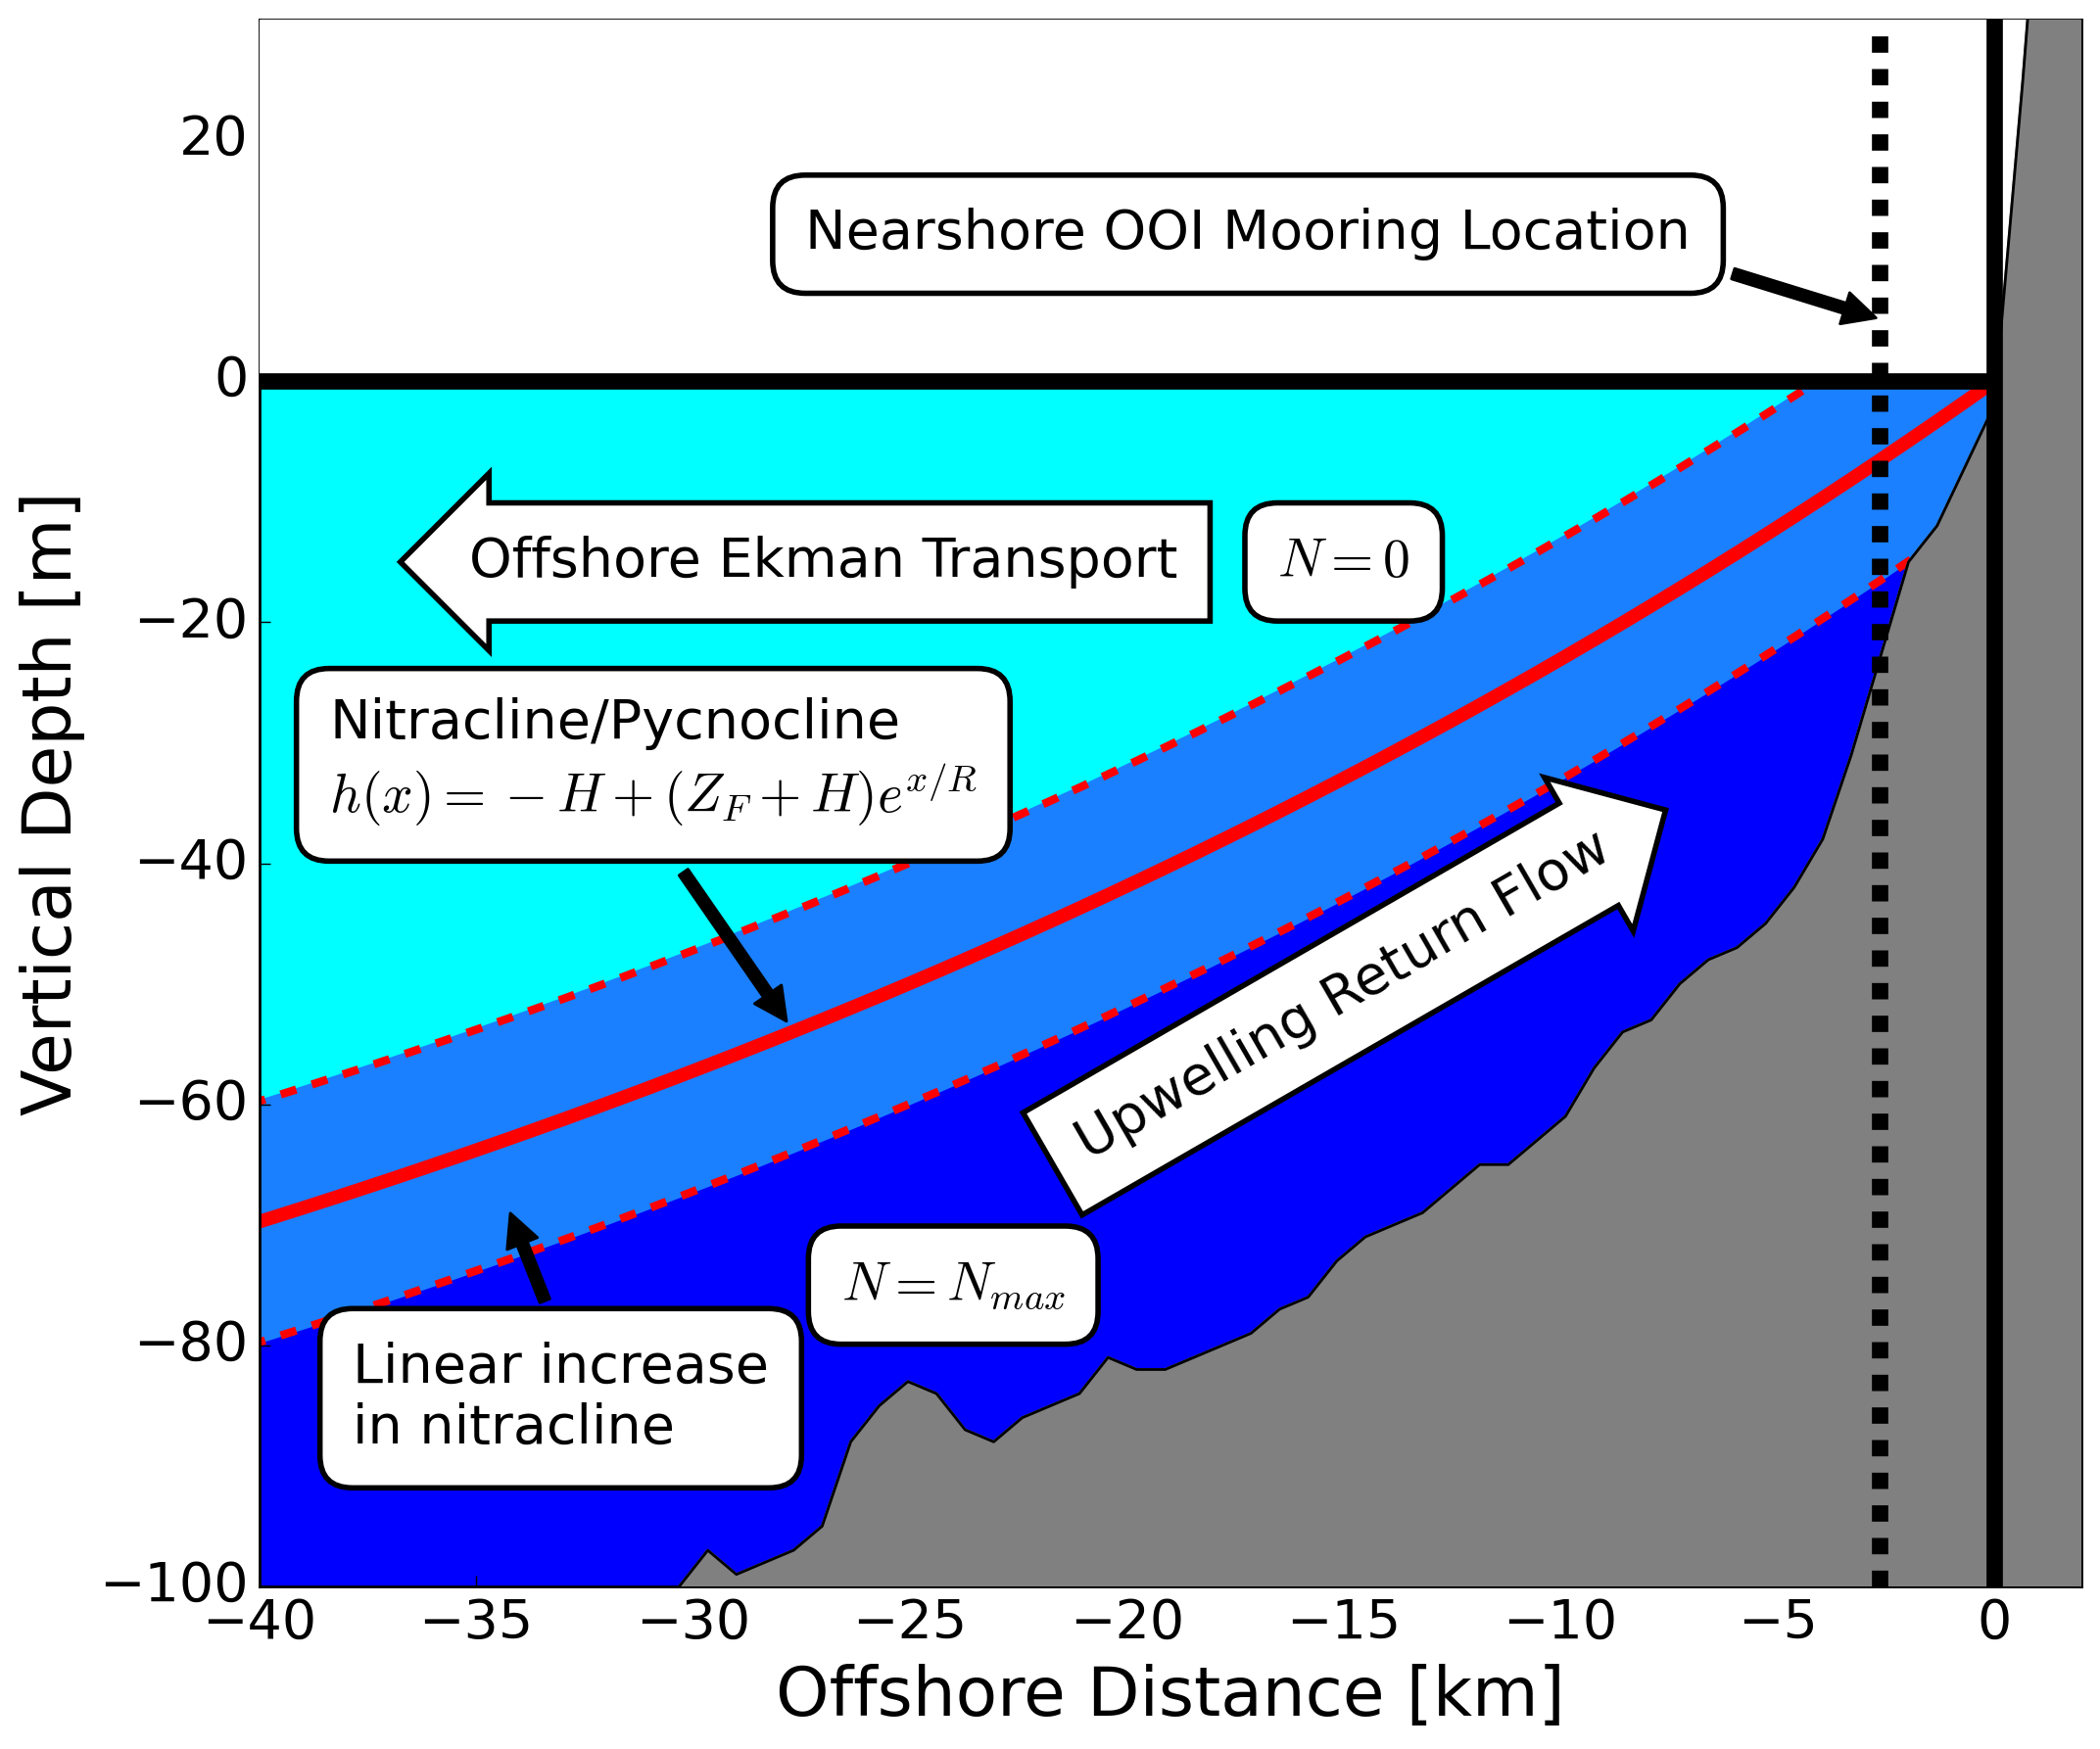

In [22]:
r=49
h=125
N=31.72364566
d = topo[-13]
zf = np.arange(-50,50,0.1)
nda = np.nan*np.zeros(len(zf))
for i,z in enumerate(zf):
    if (0 <= pycno(x0,z+h,r,h)):
        nda[i] = N
    elif (0 > pycno(x0,z+h,r,h)) & (pycno(x0,z+h,r,h) > d):
        nda[i] = -N/d*(pycno(x0,z+h,r,h)-d)
    elif (pycno(x0,z+h,r,h) <= d):
        nda[i] = 0
fig,ax = plt.subplots(figsize=(12,10))
plt.plot(meters,topo,color='black',zorder=17)
plt.xlim([-40,2])
plt.ylim([-100,30])
plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5],'red',lw=5)
plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5]+10,'--r',lw=3)
plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5]-10,'--r',lw=3)
plt.axhline(0,color='black',lw=6,zorder=15)
plt.fill_between(meters,-500,topo,color='grey',zorder=15)
plt.axvline(0,color='black',lw=6,zorder=15)
plt.axvline(-2.636240627552965,color='black',lw=6,linestyle='--',zorder=15)
plt.xlabel('Offshore Distance [km]',fontsize=25)
plt.ylabel('Vertical Depth [m]',fontsize=25)
plt.fill_between(meters,pycno(meters,125+zf[500],r),topo,meters<0.5,color='blue')
plt.fill_between(meters,pycno(meters,125+zf[500],r),0,meters<0.5,color='cyan')
plt.fill_between(meters,pycno(meters,125+zf[500],r)-10,pycno(meters,125+zf[500],r)+10,
                 meters<0.5,color=(0.1,0.5,1))
plt.text(
    -24, -75, "$N=N_{max}$", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2))
plt.text(
    -15, -51, "Upwelling Return Flow", ha="center", va="center", rotation=30, size=20,
    bbox=dict(boxstyle="rarrow,pad=0.6", fc="white", ec="black", lw=2))
plt.text(
    -15, -15, "$N=0$", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2))
plt.text(
    -27, -15, "Offshore Ekman Transport", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="larrow,pad=0.6", fc="white", ec="black", lw=2))
plt.annotate('Nitracline/Pycnocline\n$h(x)=-H+(Z_F+H)e^{x/R}$', xy=(meters[70],pycno(meters,125+zf[500],r)[70]), xytext=(0.14,0.47), 
            textcoords='figure fraction', arrowprops=dict(facecolor='black', shrink=0.05, ec='black'),
            horizontalalignment='left', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.annotate('Linear increase\nin nitracline', xy=(meters[60],pycno(meters,125+zf[500],r)[53]), xytext=(0.15,0.15), 
            textcoords='figure fraction', arrowprops=dict(facecolor='black', shrink=0.05, ec='black'),
            horizontalalignment='left', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.annotate('Nearshore OOI Mooring Location', xy=(-2.5,5), xytext=(-7,10), zorder=15,
            arrowprops=dict(facecolor='black', shrink=0.05, ec='black'),
            horizontalalignment='right', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
ax.tick_params(axis='both', which='major', labelsize=20)
plt.fill_between(meters,0,40,color='white',zorder=11)


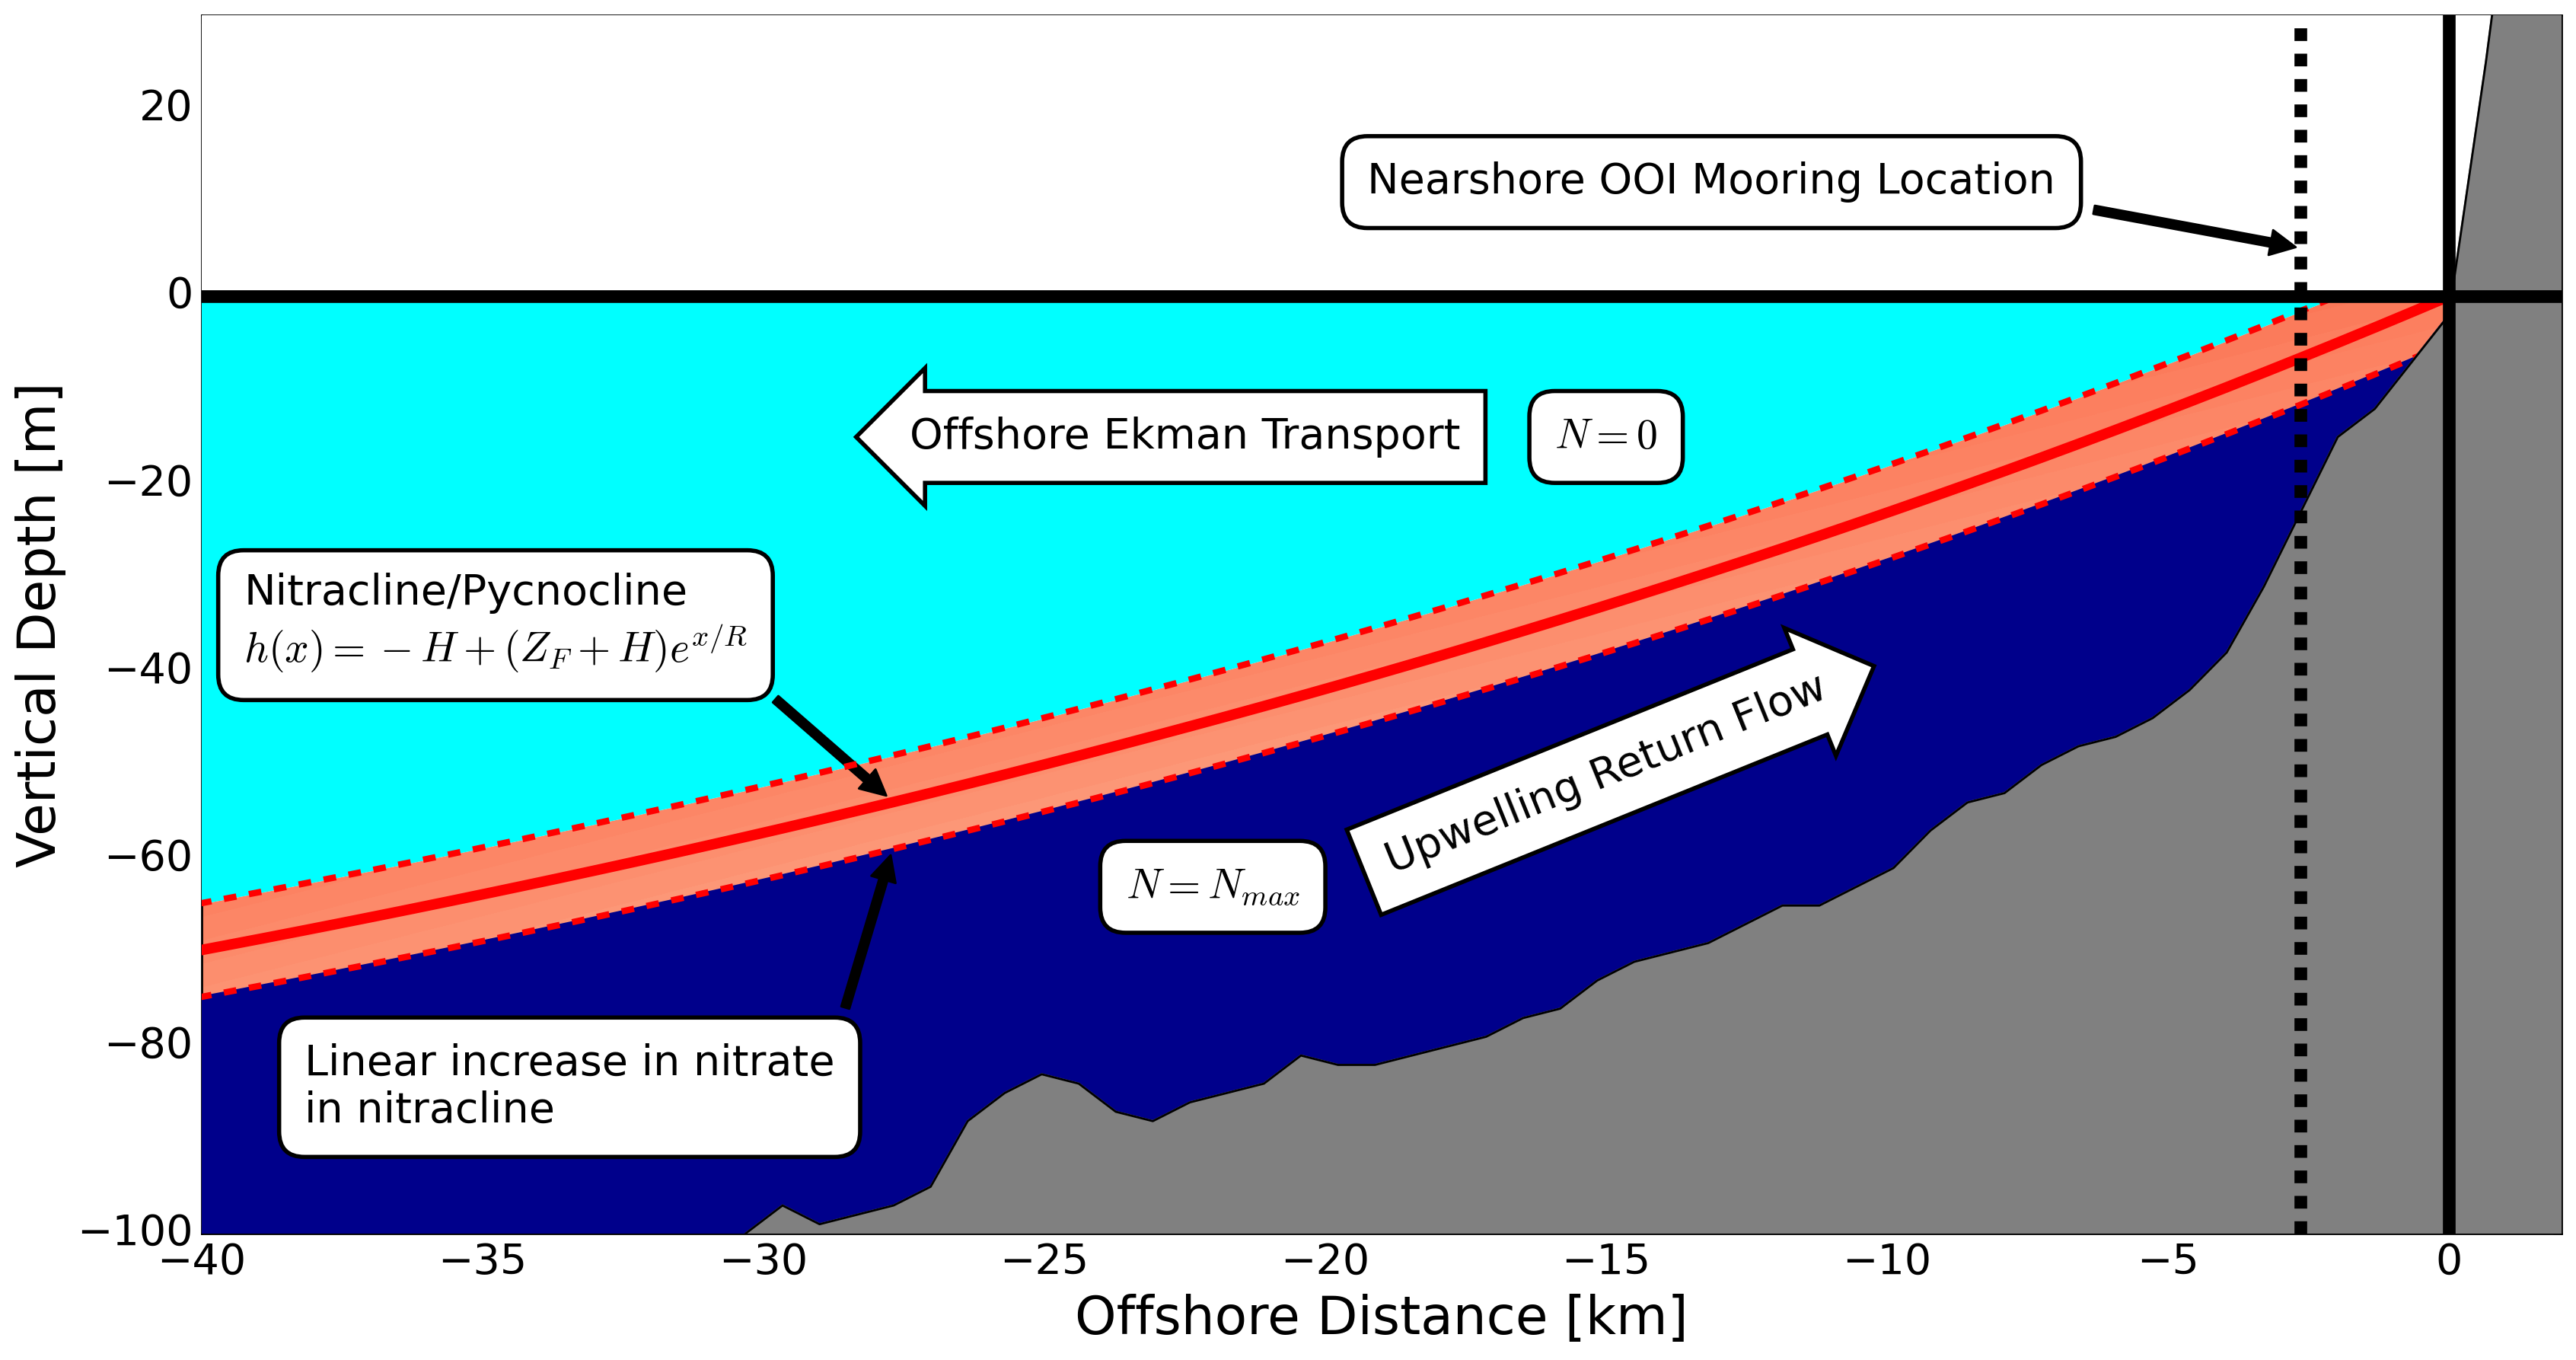

In [23]:
r=49
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(meters,topo,color='black',zorder=13)
plt.xlim([-40,2])
plt.ylim([-100,30])
plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5],'red',lw=5,zorder=11)
plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5]+5,'--r',lw=3,zorder=11)
plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5]-5,'--r',lw=3,zorder=11)

plt.axhline(0,color='black',lw=6,zorder=13)
plt.fill_between(meters,-500,topo,color='grey',zorder=12)
plt.axvline(0,color='black',lw=6,zorder=13)
plt.axvline(-2.636240627552965,color='black',lw=6,linestyle='--',zorder=13)
plt.xlabel('Offshore Distance [km]',fontsize=25)
plt.ylabel('Vertical Depth [m]',fontsize=25)
plt.fill_between(meters,pycno(meters,125+zf[500],r)-5,topo,meters<0.5,color='darkblue',zorder=10)
plt.fill_between(meters,pycno(meters,125+zf[500],r)+5,0,meters<0.5,color='cyan',zorder=10)
#plt.fill_between(meters,pycno(meters,125+zf[500],r),pycno(meters,125+zf[500],r)+5,
#                 meters<0.5,color='red',alpha=0.5)
#plt.fill_between(meters,pycno(meters,125+zf[500],r),pycno(meters,125+zf[500],r)-5,
#                 meters<0.5,color='red',alpha=0.5)
plt.text(
    -22, -63, "$N=N_{max}$", ha="center", va="center", rotation=0, size=20,zorder=10,
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2))
plt.text(
    -15, -51, "Upwelling Return Flow", ha="center", va="center", rotation=22, size=20,zorder=10,
    bbox=dict(boxstyle="rarrow,pad=0.6", fc="white", ec="black", lw=2))
plt.text(
    -15, -15, "$N=0$", ha="center", va="center", rotation=0, size=20, zorder=10,
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2))
plt.text(
    -22.5, -15, "Offshore Ekman Transport", ha="center", va="center", rotation=0, size=20, zorder=10,
    bbox=dict(boxstyle="larrow,pad=0.6", fc="white", ec="black", lw=2))
plt.annotate('Nitracline/Pycnocline\n$h(x)=-H+(Z_F+H)e^{x/R}$', xy=(meters[70],pycno(meters,125+zf[500],r)[70]), xytext=(0.08,0.45), zorder=10,
            textcoords='figure fraction', arrowprops=dict(facecolor='black', shrink=0.05, ec='black'),
            horizontalalignment='left', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.annotate('Linear increase in nitrate\nin nitracline', xy=(meters[70],pycno(meters,125+zf[500],r)[65]), xytext=(0.1,0.15), zorder=10,
            textcoords='figure fraction', arrowprops=dict(facecolor='black', shrink=0.05, ec='black'),
            horizontalalignment='left', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.annotate('Nearshore OOI Mooring Location', xy=(-2.5,5), xytext=(-7,10), zorder=17,
            arrowprops=dict(facecolor='black', shrink=0.05, ec='black'),
            horizontalalignment='right', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.fill_between(meters,0,40,color='white',zorder=11)
ax.tick_params(axis='both', which='major', labelsize=20)

x = meters[meters<0.5]
y = pycno(meters,125+zf[500],r)[meters<0.5]+5
z = np.array([(pycno(meters,125+zf[500],r)[meters<0.5]+5-z) for z in range(len(x))])
num_bars = 100  # more bars = smoother gradient
plt.contourf(x, y, z.T, num_bars,zorder=1,cmap='Reds')

background_color = 'w'
plt.fill_between(x, y, y2=max(y), color=background_color)

In [24]:
r=49
h=125
N=31.72364566
d = topo[-13]
zf = np.arange(-50,50,0.1)
nda = np.nan*np.zeros(len(zf))
for i,z in enumerate(zf):
    if (0 <= pycno(x0,z+h,r,h)):
        nda[i] = N
    if (0 > pycno(x0,z+h,r,h)) & (pycno(x0,z+h,r,h) > d):
        nda[i] = -N/d*(pycno(x0,z+h,r,h)-d)
    if (pycno(x0,z+h,r,h) <= d):
        nda[i] = 0

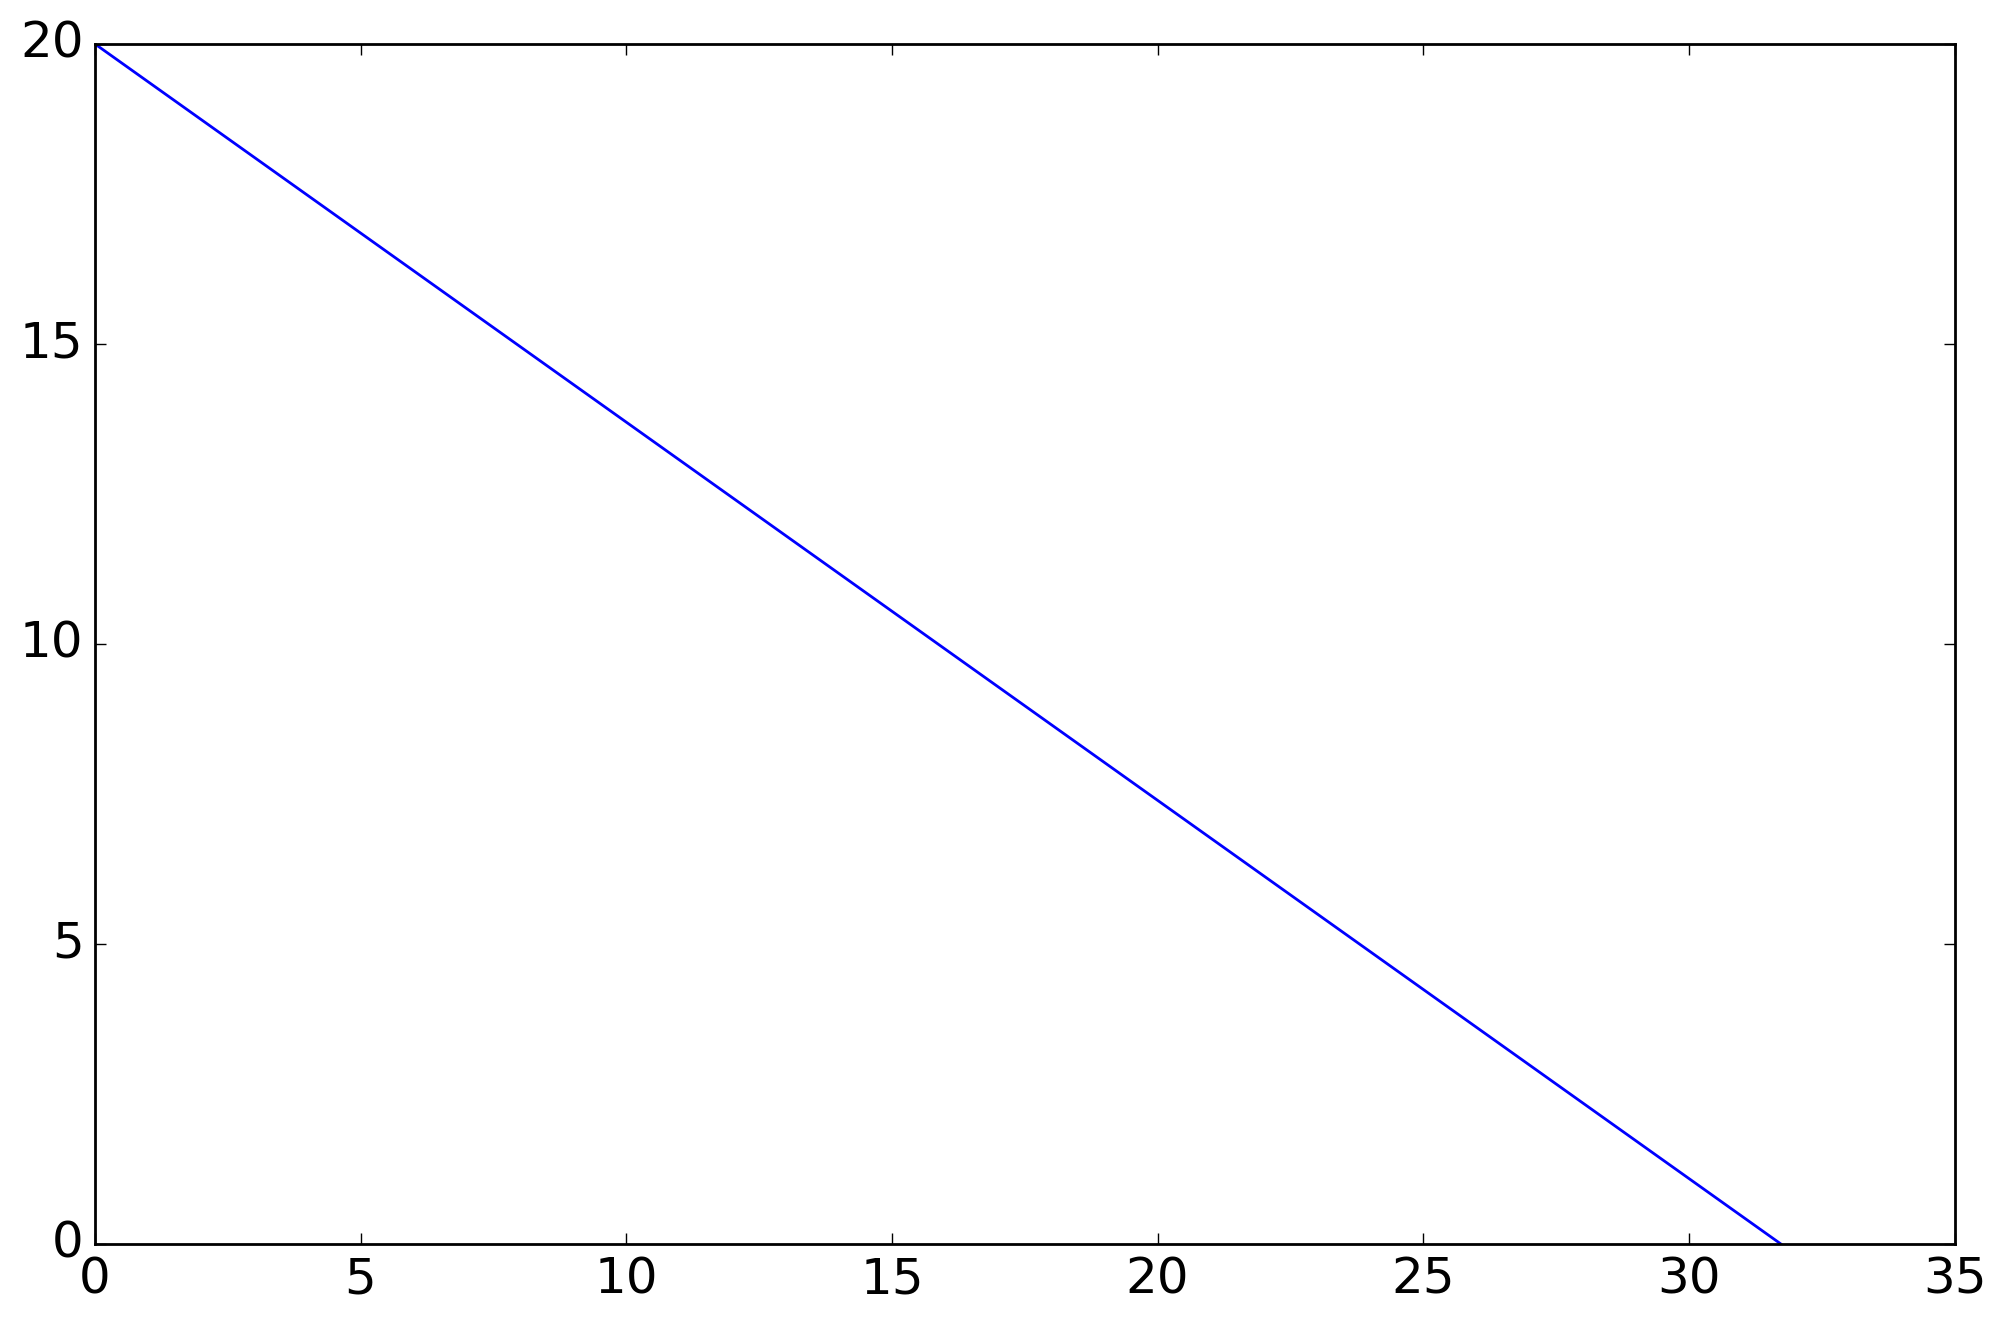

In [25]:
def logistic(x, a, b, c):
    #x=input array, a=growth rate, b=max value, c=center of curve
    output = b/(1+np.exp(-a*(x-c)))
    return output
delta = 20 #nitracline width in meters
step = 0.1
vert_z = np.arange(0,delta+step,step) #vertical depth z
vert_n = np.flip(N/delta*vert_z) #linear nitracline
#vert_n = logistic(vert_z,0.5,N,5)
#vert_n[0],vert_n[-1] = 0,N
plt.plot(vert_n,vert_z)

In [26]:
delta = 20 #nitracline width in meters
step = 0.1
r = 50
h = 125
N = 31.72364566


pycno_width = np.nan*np.zeros(len(vert_z))
for i,z in enumerate(zf):
    if (0 <= pycno(x0,z+h,r,h)-delta/2):
        nda[i] = N
    if (0 > pycno(x0,z+h,r,h)-delta/2) & (d < pycno(x0,z+h,r,h)+delta/2):
        #make some copies so I don't screw up the initial arrays...
        temp_n = np.copy(vert_n)
        temp_p = np.copy(pycno(x0,z+h,r,h)+vert_z-delta/2)
        #a lot of effort to remove a few wiggles...
        #the next two if statements deal with the fact that
        #the pycno=0 and pycno=d are not necessarily included 
        #in the calculations over all z, which then throws off 
        #the integration by missing the ends
        if not np.all(pycno(x0,z+h,r,h)+vert_z-delta/2 < 0):
            negmask = temp_p < 0
            posmask = temp_p > 0
            n_zero = np.interp(np.array([0]),
                                [temp_p[negmask][-1],temp_p[posmask][0]],
                                [temp_n[negmask][-1],temp_n[posmask][0]])
            temp_p = np.append(temp_p,0)
            temp_n = np.append(vert_n,n_zero)
            temp_p = np.sort(temp_p)
            temp_n = np.flip(np.sort(temp_n))
        if not np.all(pycno(x0,z+h,r,h)+vert_z-delta/2-d > 0):
            negmask = temp_p-d < 0
            posmask = temp_p-d > 0
            n_zero = np.interp(np.array([0]),
                                [temp_p[negmask][-1],temp_p[posmask][0]],
                                [temp_n[negmask][-1],temp_n[posmask][0]])
            temp_p = np.append(temp_p,-23)
            temp_n = np.append(temp_n,n_zero)
            temp_p = np.sort(temp_p)
            temp_n = np.flip(np.sort(temp_n))
        #here the nitracline arrays are appended with 0 nitrate above the nitracline
        #and Nmax nitrate below the nitracline
        temp_z_t = np.arange(np.ceil((pycno(x0,z+h,r,h)+vert_z-delta/2)[-1]),0.5,0.5)
        temp_n_t = np.full(len(temp_z_t),0)
        temp_z_b = np.arange(d,np.floor((pycno(x0,z+h,r,h)+vert_z-delta/2)[0])+0.5,0.5)
        temp_n_b = np.full(len(temp_z_b),N) 
        temp_z_f = np.append(temp_z_b,np.append(temp_p,temp_z_t))
        temp_n_f = np.append(temp_n_b,np.append(temp_n,temp_n_t))
        #mask values above 0 and below d, integrate
        mask = (temp_z_f >= d) & (temp_z_f <= 0)
        nda[i] = simps(temp_n_f[mask],temp_z_f[mask])/-d
        if i==430:
            nitracline_depth = temp_z_f[mask]
            nitracline_nitra = temp_n_f[mask]
    if (d >= pycno(x0,z+h,r,h)+delta/2):
        nda[i] = 0

In [27]:
delta = 20 #nitracline width in meters
step = 0.1
r = 50
h = 125
N = 31.72364566
zf = np.arange(-50,50,0.1)
x0 = meters[-13]
d = topo[-13]
vert_z = np.arange(0,delta+step,step) #vertical depth z
vert_n = np.flip(N/delta*vert_z) #linear nitracline
nda = np.nan*np.zeros(len(zf))
pycno_width = np.nan*np.zeros(len(vert_z))
nitracline_depth = []
nitracline_nitra = []
nitracline_zf = []
#regime transition points
regime = []
regime.append(find_nearest(pycno(x0,125+zf,50),d-delta/2)[0])
regime.append(find_nearest(pycno(x0,125+zf,50),d+delta/2)[0])
regime.append(find_nearest(pycno(x0,125+zf,50),0-delta/2)[0])
regime.append(find_nearest(pycno(x0,125+zf,50),0+delta/2)[0])
for i,z in enumerate(zf):
    if (0 <= pycno(x0,z+h,r,h)-delta/2):
        nda[i] = N
        if i in regime:
            print(i,'N')
    if (0 > pycno(x0,z+h,r,h)-delta/2) & (d < pycno(x0,z+h,r,h)+delta/2):
        #make some copies so I don't screw up the initial arrays...
        temp_n = np.copy(vert_n)
        temp_p = np.copy(pycno(x0,z+h,r,h)+vert_z-delta/2)
        #a lot of effort to remove a few wiggles...
        #the next two if statements deal with the fact that
        #the pycno=0 and pycno=d are not necessarily included 
        #in the calculations over all z, which then throws off 
        #the integration by missing the ends
        if not np.all(pycno(x0,z+h,r,h)+vert_z-delta/2 < 0):
            negmask = temp_p < 0
            posmask = temp_p > 0
            n_zero = np.interp(np.array([0]),
                                [temp_p[negmask][-1],temp_p[posmask][0]],
                                [temp_n[negmask][-1],temp_n[posmask][0]])
            temp_p = np.append(temp_p,0)
            temp_n = np.append(vert_n,n_zero)
            temp_p = np.sort(temp_p)
            temp_n = np.flip(np.sort(temp_n))
        if not np.all(pycno(x0,z+h,r,h)+vert_z-delta/2-d > 0):
            negmask = temp_p-d < 0
            posmask = temp_p-d > 0
            n_zero = np.interp(np.array([0]),
                                [temp_p[negmask][-1],temp_p[posmask][0]],
                                [temp_n[negmask][-1],temp_n[posmask][0]])
            temp_p = np.append(temp_p,-23)
            temp_n = np.append(temp_n,n_zero)
            temp_p = np.sort(temp_p)
            temp_n = np.flip(np.sort(temp_n))
        #here the nitracline arrays are appended with 0 nitrate above the nitracline
        #and Nmax nitrate below the nitracline
        temp_z_t = np.arange(np.ceil((pycno(x0,z+h,r,h)+vert_z-delta/2)[-1]),0.5,0.5) #depth at top
        temp_n_t = np.full(len(temp_z_t),0) #nitr at top
        temp_z_b = np.arange(d,np.floor((pycno(x0,z+h,r,h)+vert_z-delta/2)[0])+0.5,0.5) #depth at bottom
        temp_n_b = np.full(len(temp_z_b),N)  # nitr at bottom
        temp_z_f = np.append(temp_z_b,np.append(temp_p,temp_z_t)) #"final" depth array -- NOT Z_F in model!!
        temp_n_f = np.append(temp_n_b,np.append(temp_n,temp_n_t)) #"final" nitrate array for integration
        #print(pycno(x0,z+h,r,h),temp_z_f,temp_n_f)

        #mask values above 0 and below d, integrate
        #mask = (temp_z_f >= d) & (temp_z_f <= 0)
        #nda[i] = simps(temp_n_f[mask],temp_z_f[mask])/-d
        
        #print(i)
        if i in regime:
            nitracline_depth.append(temp_z_f)
            nitracline_nitra.append(temp_n_f)
            nitracline_zf.append(zf[i])
            #print(i,zf[i],pycno(x0,zf[i]+h,r),temp_z_f,temp_n_f)
        '''#if i==400:
            nitracline_depth.append(temp_z_f[mask])
            nitracline_nitra.append(temp_n_f[mask])
            nitracline_zf.append(zf[i])
        #if i==500:
            nitracline_depth.append(temp_z_f[mask])
            nitracline_nitra.append(temp_n_f[mask])
            nitracline_zf.append(zf[i])
        #if i==588:
            nitracline_depth.append(temp_z_f[mask])
            nitracline_nitra.append(temp_n_f[mask])
            nitracline_zf.append(zf[i])
        '''
    if (d >= pycno(x0,z+h,r,h)+delta/2):
        nda[i] = 0
        if i in regime:
            print(i,'0')

In [28]:
nitracline_zf

[-27.999999999999687,
 -6.8999999999993875,
 -3.7999999999993435,
 17.30000000000095]

In [29]:
for i in range(4):
    nitracline_nitra[i] = np.append([N],nitracline_nitra[i])
    nitracline_depth[i] = np.append([-50],nitracline_depth[i])
    nitracline_nitra[i] = np.append(nitracline_nitra[i],[0])
    nitracline_depth[i] = np.append(nitracline_depth[i],[30])

In [30]:
nitracline_depth

[array([-50.        , -42.98182002, -42.88182002, -42.78182002,
        -42.68182002, -42.58182002, -42.48182002, -42.38182002,
        -42.28182002, -42.18182002, -42.08182002, -41.98182002,
        -41.88182002, -41.78182002, -41.68182002, -41.58182002,
        -41.48182002, -41.38182002, -41.28182002, -41.18182002,
        -41.08182002, -40.98182002, -40.88182002, -40.78182002,
        -40.68182002, -40.58182002, -40.48182002, -40.38182002,
        -40.28182002, -40.18182002, -40.08182002, -39.98182002,
        -39.88182002, -39.78182002, -39.68182002, -39.58182002,
        -39.48182002, -39.38182002, -39.28182002, -39.18182002,
        -39.08182002, -38.98182002, -38.88182002, -38.78182002,
        -38.68182002, -38.58182002, -38.48182002, -38.38182002,
        -38.28182002, -38.18182002, -38.08182002, -37.98182002,
        -37.88182002, -37.78182002, -37.68182002, -37.58182002,
        -37.48182002, -37.38182002, -37.28182002, -37.18182002,
        -37.08182002, -36.98182002, -36.

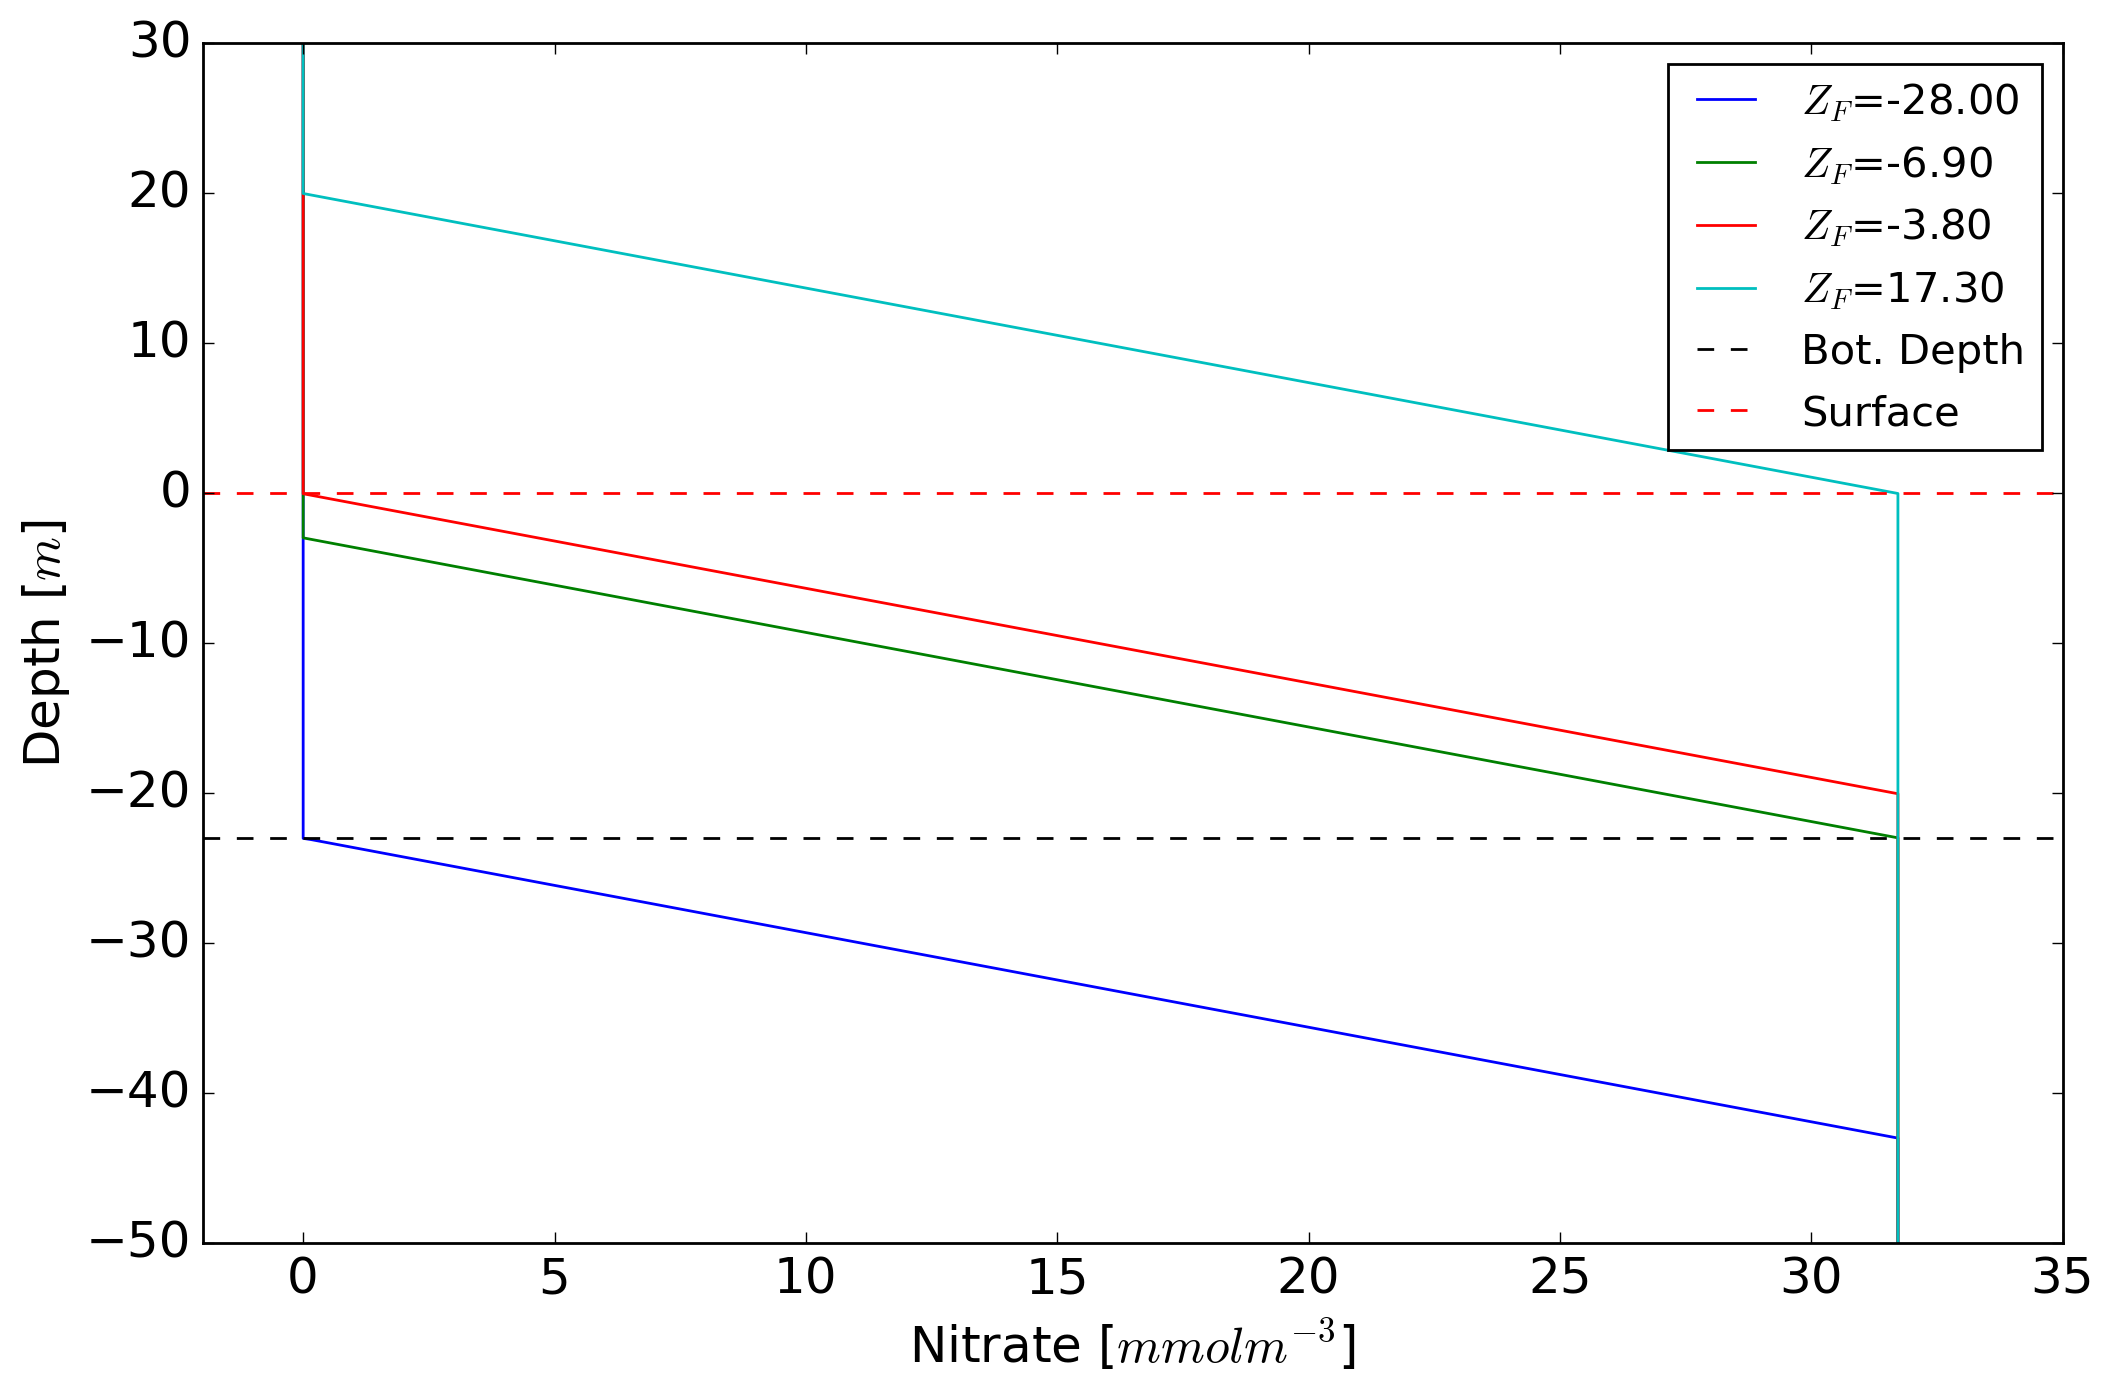

In [31]:
for i in range(4):
    plt.plot(nitracline_nitra[i],nitracline_depth[i], label=f'$Z_F$={nitracline_zf[i]:.2f}')
plt.xlim([-2,35])
plt.xlabel('Nitrate [$mmol m^{-3}$]')
plt.ylabel('Depth [$m$]')
plt.axhline(-23,color='black',linestyle='--',label='Bot. Depth')
plt.axhline(0,color='red',linestyle='--',label='Surface')
plt.legend(fontsize=15)
#plt.axhline(-)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


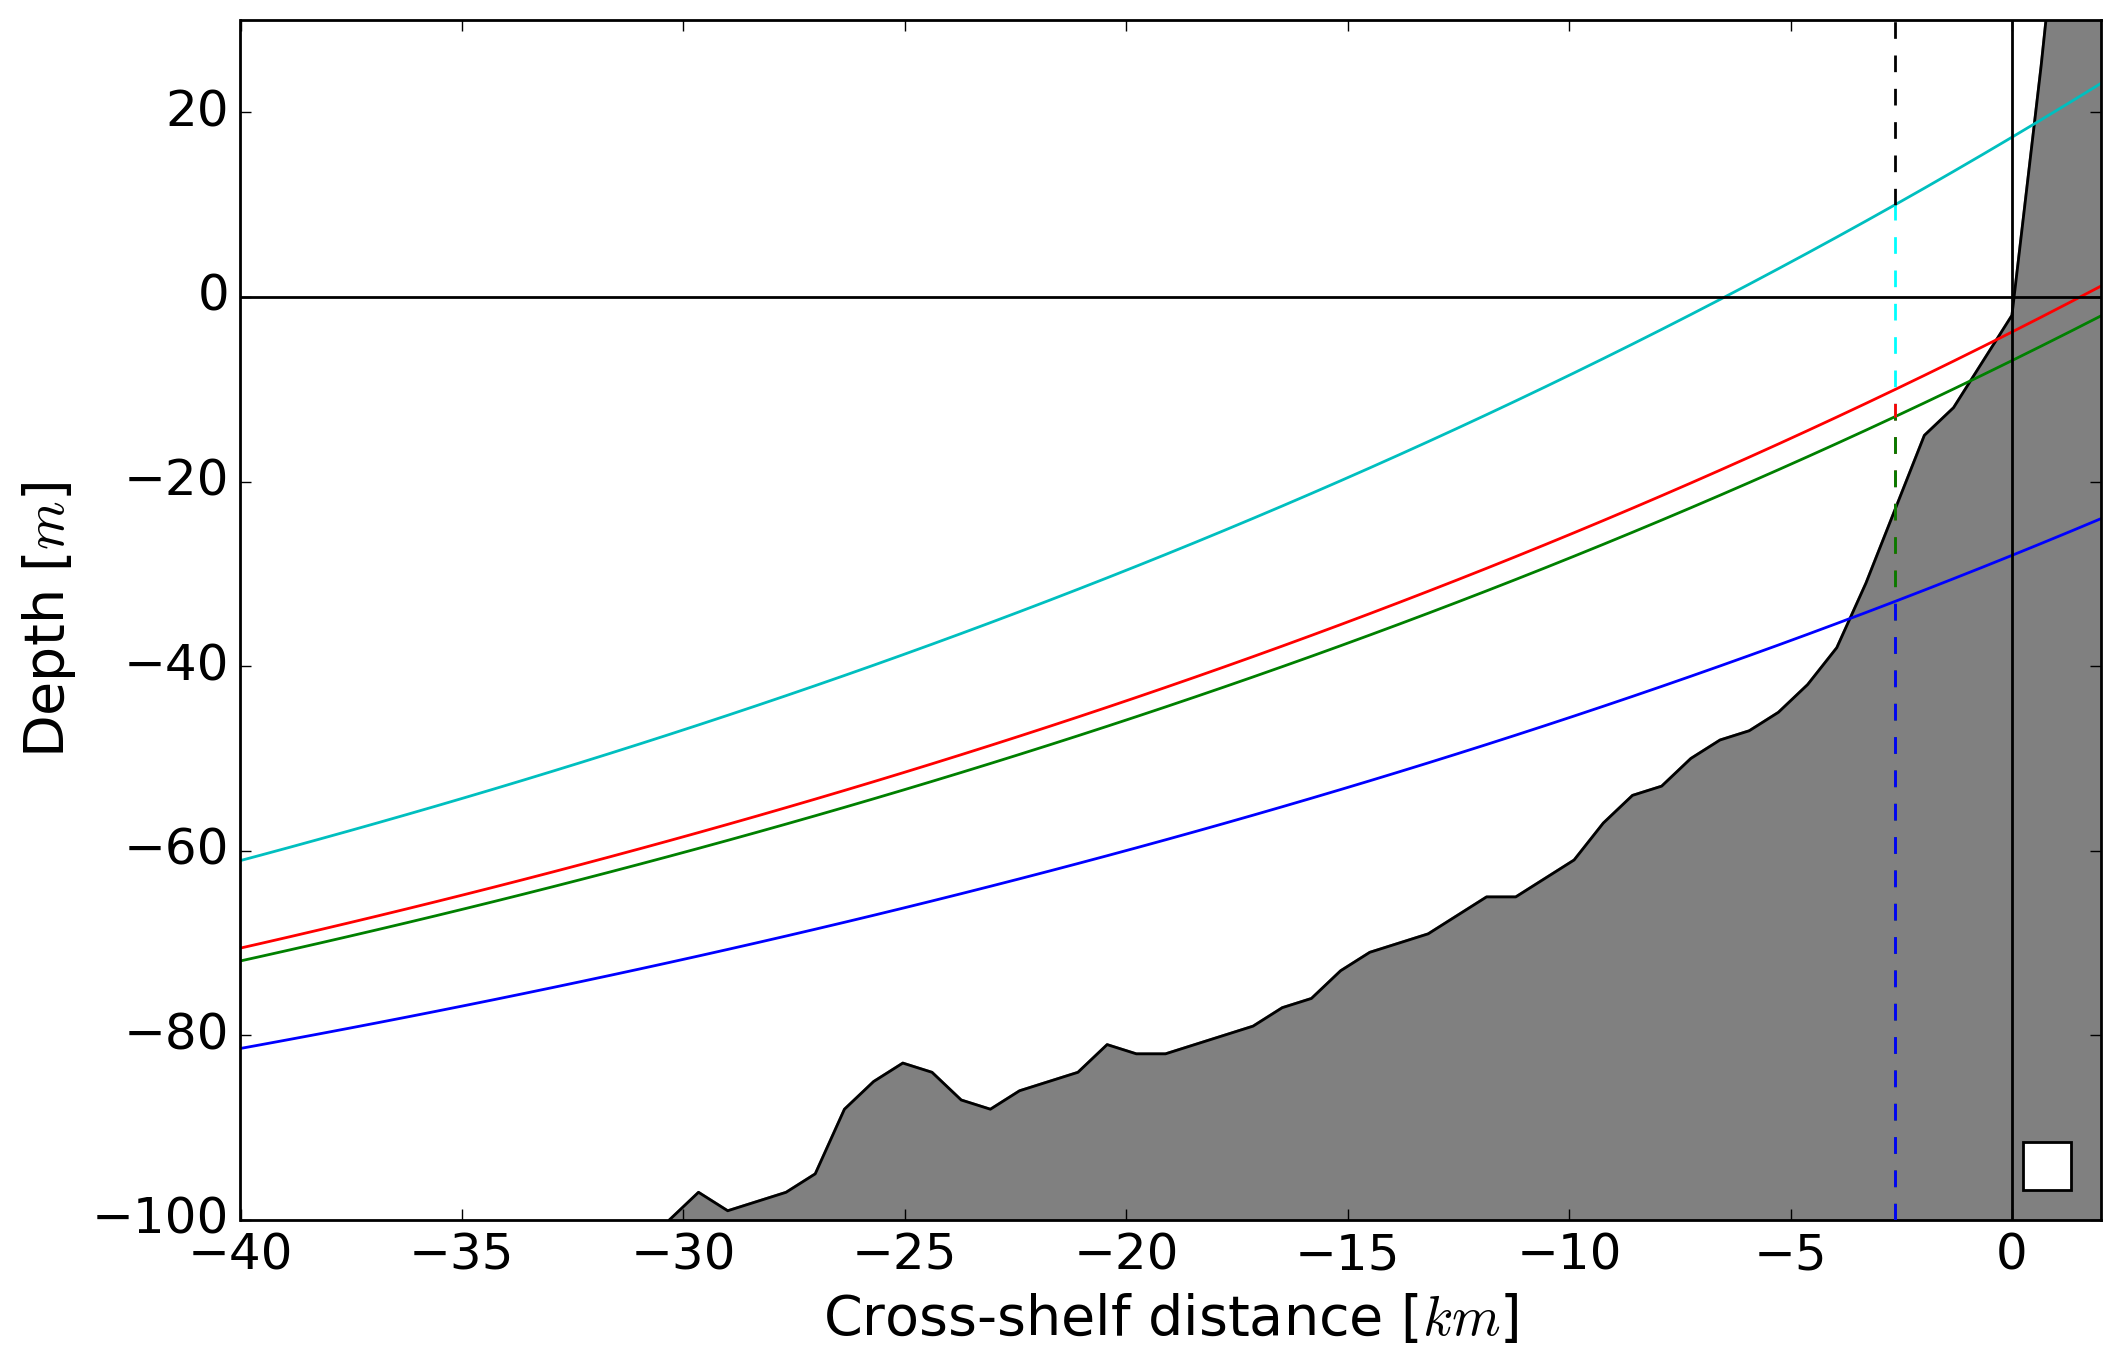

In [32]:
r=50
#plt.figure(figsize=(20,10))
plt.plot(meters,topo,color='black')
plt.xlim([-40,2])
plt.ylim([-100,30])
c = ['blue','green','red','cyan']
for i,z in enumerate(nitracline_zf):
    plt.plot(meters,pycno(meters,125+z,r))
    plt.axvline(x0,ymin=0,ymax=(100+pycno(x0,125+z,r))/130,
                linestyle='--',color=c[i],zorder=50-i*5)
plt.axvline(x0,ymin=(100+pycno(x0,125+nitracline_zf[3],r))/130,ymax=1,
            linestyle='--',color='black')
#plt.plot(meters,pycno(meters,125+8.80,r),label=f'$Z_F$={8.80:.2f}')
#plt.plot(meters,pycno(meters,125+zf[400],r),label=f'$Z_F$={zf[400]:.0f}')
#plt.plot(meters,pycno(meters,125+zf[500],r),label=f'$Z_F$={zf[500]:.0f}')
#plt.plot(meters,pycno(meters,125+zf[600],r),label=f'$Z_F$={zf[600]:.0f}')
plt.axhline(0,color='black')
plt.fill_between(meters,-500,topo,color='grey')
plt.axvline(0,color='black')
#plt.axhline(8.80,color='red',linestyle='--',label='$Z_F$=8.80')
#plt.axvline(x0,color='black',linestyle='--',label='$x_0$')
plt.xlabel('Cross-shelf distance [$km$]',fontsize=20)
plt.ylabel('Depth [$m$]',fontsize=20)
plt.legend(loc=4)

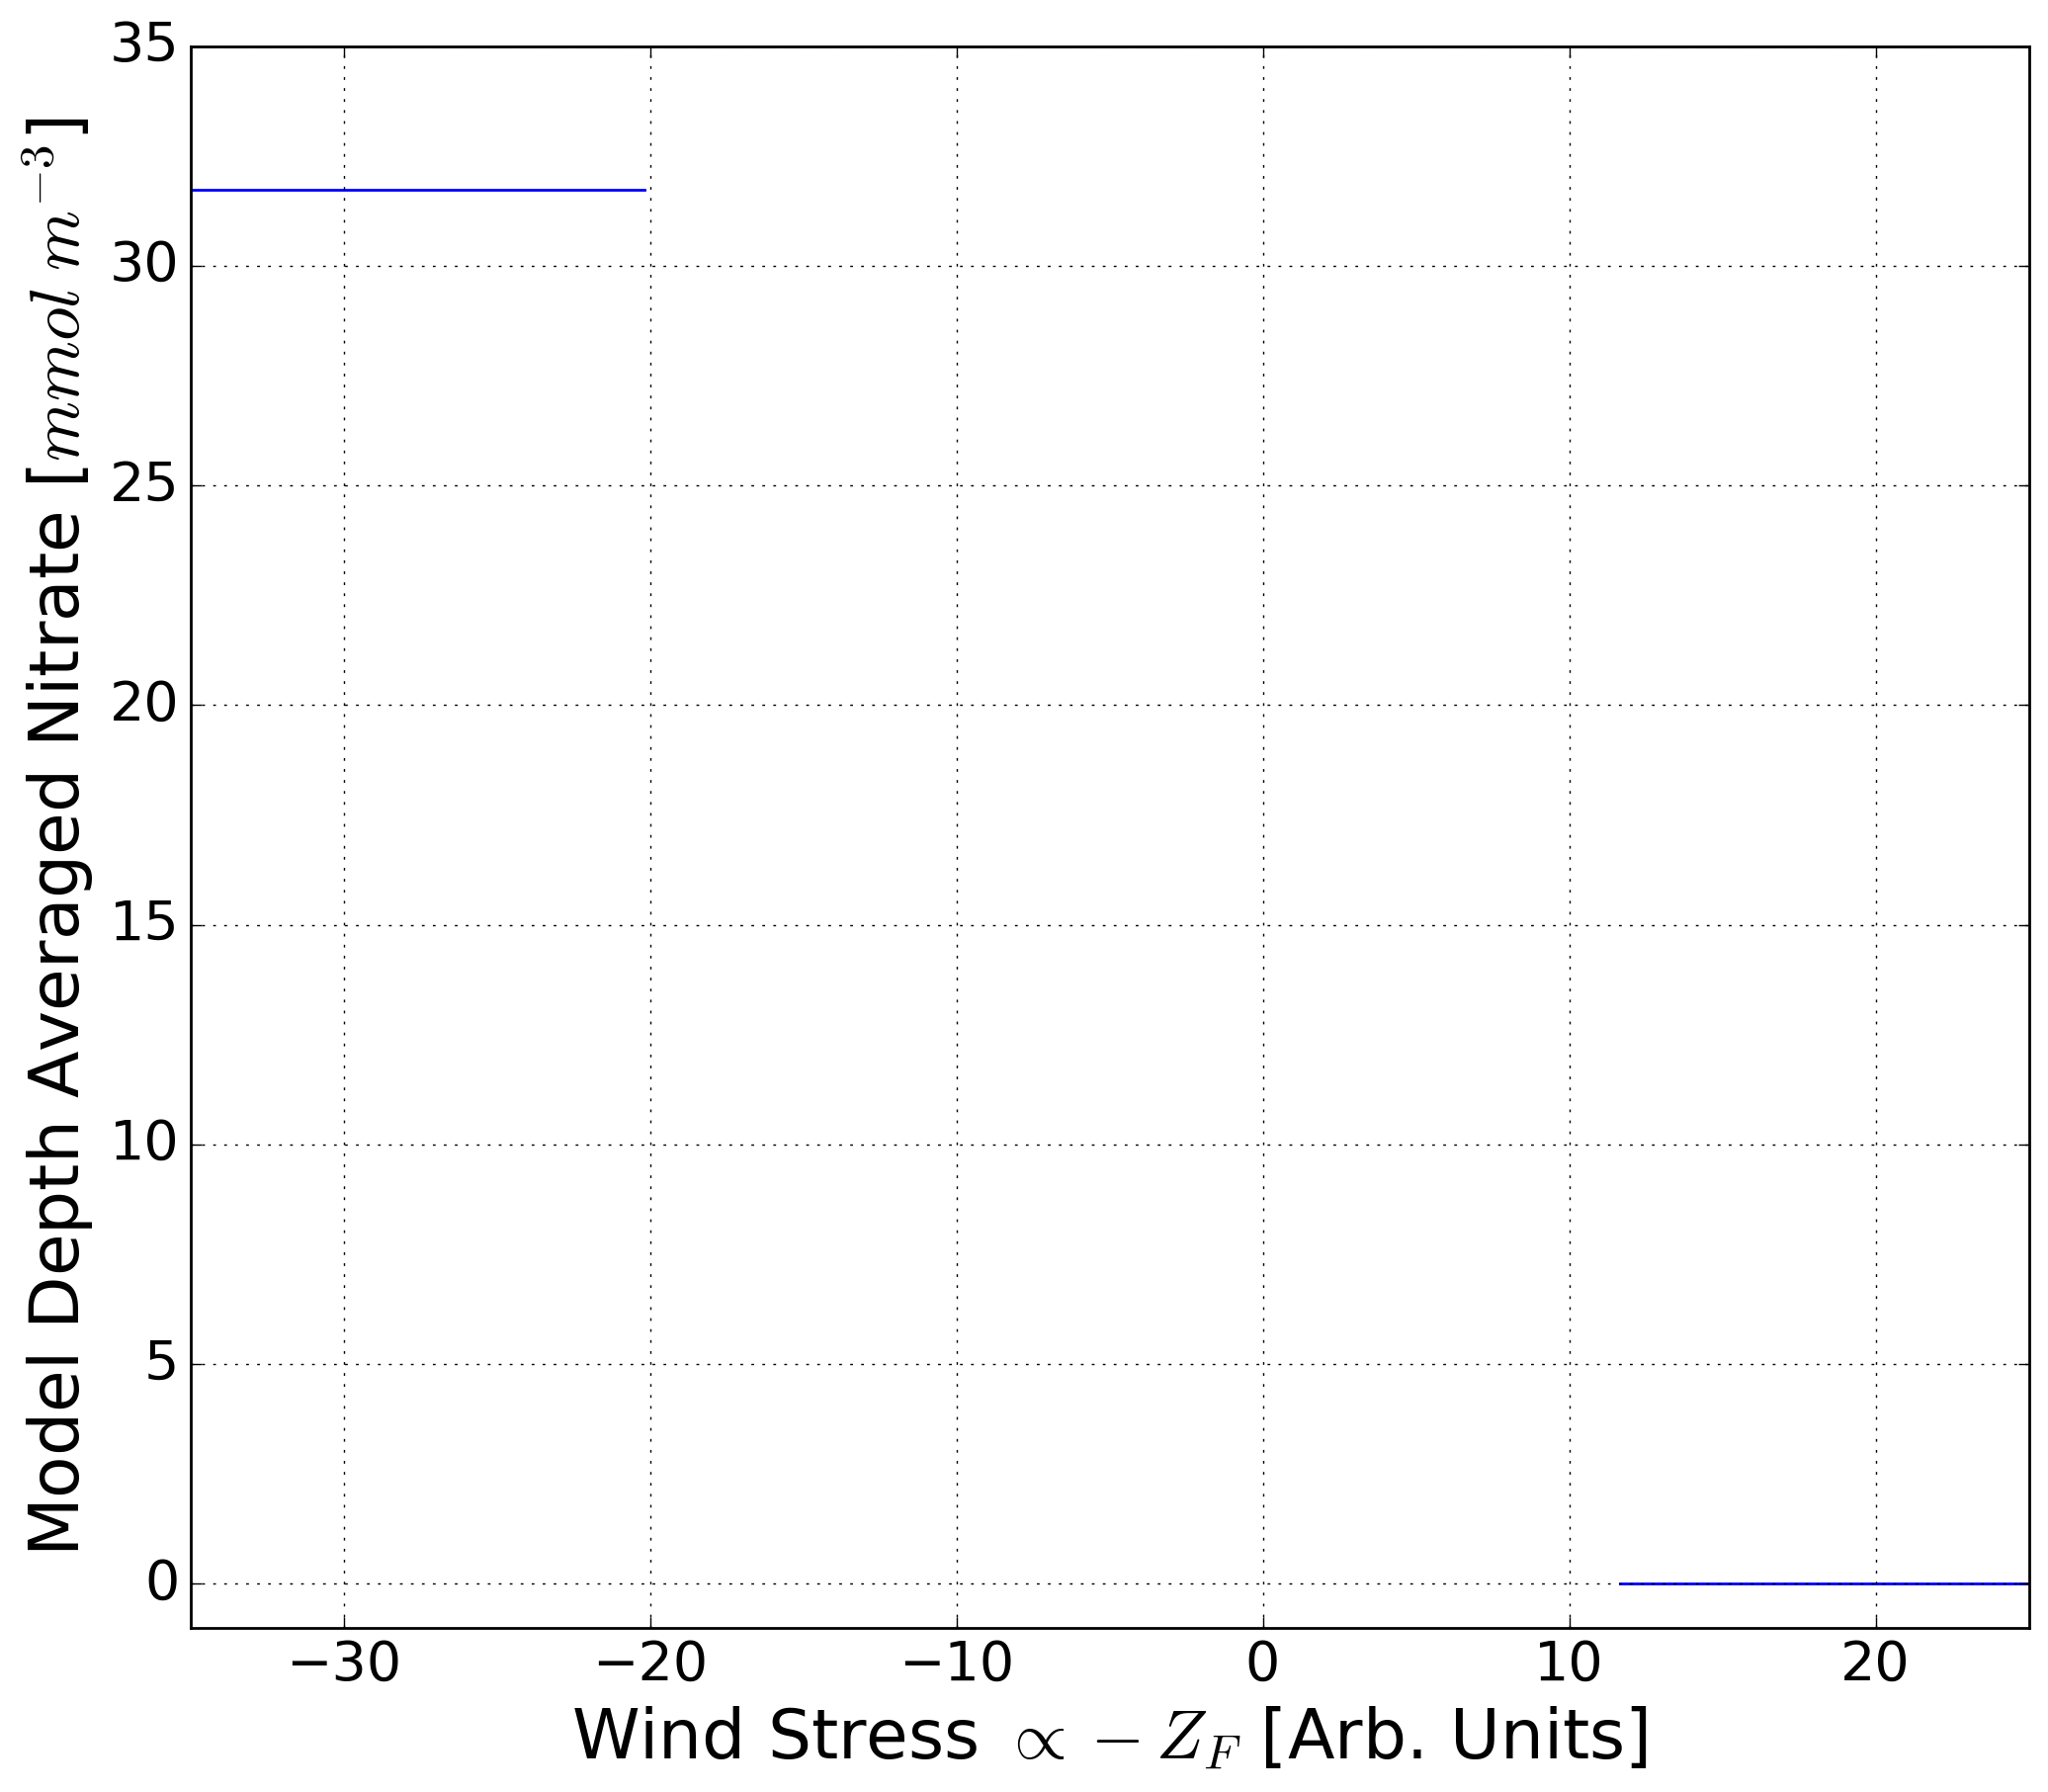

In [33]:
fig,ax = plt.subplots(figsize=(12,10))

plt.plot(-0.7*zf-8,nda)
plt.xlabel('Wind Stress $\\propto -Z_F$ [Arb. Units]',fontsize=25)
plt.ylabel('Model Depth Averaged Nitrate [$mmol \; m^{-3}$]',fontsize=25)
plt.grid()
plt.xlim([-35,25])
plt.ylim([-1,35])
ax.tick_params(axis='both', which='major', labelsize=20)

In [34]:
for i,z in enumerate(vert_z):
    if z < -h-delta/2:
        vert_n[i] = 0
    if z > -h+delta/2:
        vert_n[i] = N
    if (z >= -h-delta/2) & (z <= -h+delta/2):
        vert_n[i] = (z+h)*N/delta+N/2

In [35]:
dsfasd

NameError: name 'dsfasd' is not defined

In [ ]:
fklfdslj
plt.plot(vert_z,vert_n)fd

In [ ]:
d

In [ ]:
r=49
from matplotlib.patches import Ellipse, Circle
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(meters,topo,color='black',zorder=11)
plt.xlim([-40,2])
plt.ylim([-100,30])
#plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5],'red',lw=5)
#plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5]+5,'--r',lw=3)
#plt.plot(meters[meters<0.5],pycno(meters,125+zf[500],r)[meters<0.5]-5,'--r',lw=3)

plt.axhline(0,color='black',lw=6,zorder=11)
plt.fill_between(meters,-500,topo,color='grey',zorder=10.5)
plt.axvline(0,color='black',lw=6,zorder=11)
plt.axvline(x0,color='black',lw=6,linestyle='--',zorder=11)
plt.xlabel('Offshore Distance [km]',fontsize=25)
plt.ylabel('Vertical Depth [m]',fontsize=25)
plt.fill_between(meters,pycno(meters,125+zf[500],r),topo,meters<0.5,color='cyan')
plt.fill_between(meters,pycno(meters,125+zf[500],r),0,meters<0.5,color='cyan')
colors=[(0,0,0.9),(0,0,0.7),(0,0,0.4),(0,0,0.1)]
#print(colors[0])
'''for i in range(1,5):
    plt.axhline(-i*20,color='red',lw=3,zorder=2)
    plt.fill_between(meters,-i*20-20,-i*20,color=colors[i-1])
'''
for i in range(1,5):
    plt.plot(meters,-i*20+50*np.exp(meters/10),'--',zorder=6,color='red',
             lw=3)
    plt.fill_between(meters,-i*20+50*np.exp(meters/10)-30,-i*20+50*np.exp(meters/10),
                     color=colors[i-1],interpolate=True,zorder=i)
    #plt.fill_between(meters,-i*20+50*np.exp(meters/10)-30,0,
    #                 -i*20+50*np.exp(meters/10)>0,color=colors[i-1],interpolate=True,step='post')

plt.fill_between(meters,0,30,color='white',zorder=7)
for i in range(3):
    ax.add_artist(Ellipse((-15-i*2.3,15), 2, 12,color='white',ec='black',zorder=8))
    ax.add_artist(Ellipse((-15-i*2.3,15), 0.5, 3,color='black',ec='black',zorder=8))

    #circ = plt.Ellipse((0,0),5,5)
    #ax.add_patch(circ)
plt.annotate('Equatorward Wind Stress', xy=(-21,15), xytext=(-23,13), zorder=8, 
            arrowprops=dict(facecolor='black', shrink=0.05, ec='black'),
            horizontalalignment='right', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.text(
    -8, -10, "Offshore Ekman Transport", ha="center", va="center", rotation=0, size=20, zorder=20,
    bbox=dict(boxstyle="larrow,pad=0.6", fc="white", ec="black", lw=2))
plt.text(
    -25, -45, "Upwelling Return Flow", ha="center", va="center", rotation=4, size=20,
    bbox=dict(boxstyle="rarrow,pad=0.6", fc="white", ec="black", lw=2))
plt.annotate('Isopycnals modeled as exponentials\n$h(x)=-H+(Z_F+H)e^{x/R}$',
            xy=(-7,-35), xytext=(-8,-90), zorder=20,
            arrowprops=dict(facecolor='black', shrink=0.05, ec='white'),
            horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.annotate('Isopycnals modeled as exponentials\n$h(x)=-H+(Z_F+H)e^{x/R}$',
            xy=(-11,-63), xytext=(-8,-90), zorder=20,
            arrowprops=dict(facecolor='black', shrink=0.05, ec='white'),
            horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
'''
plt.annotate('Isopycnals', xy=(-7,-40), xytext=(-2,-60), zorder=20,
            arrowprops=dict(facecolor='black', shrink=0.05, ec='white'),
            horizontalalignment='right', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
plt.annotate('Isopycnals', xy=(-10,-60), xytext=(-2,-60), zorder=20,
            arrowprops=dict(facecolor='black', shrink=0.05, ec='white'),
            horizontalalignment='right', verticalalignment='bottom', color='black', fontsize=20,
            bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2)
            )
'''
plt.text(
    -30, -70, "High Nitrate\nin Deep Water", ha="center", va="center", rotation=0, size=20, zorder=20,
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2))
'''
plt.text(
    -35, -10, "Low Nitrate\nin Surface Water", ha="center", va="center", rotation=0, size=20, zorder=20,
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2))
'''
im = plt.imread('imgs\\plankton.png')
for i in range(5):
    newax = fig.add_axes([0.1+0.1*i,0.6,0.1,0.1], anchor='NE', zorder=20)
    newax.imshow(im)
    newax.axis('off')
'''
plt.text(
    -22, -63, "$\\dot$", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2))
'''
pass

# Function for NDA as a function of Wind stress

In [ ]:
def nda_model(ws,m=-0.7,b=-8,r=50,h=125,x0=-2.6,d=-23,delta=20,step=0.1,Nmax=35,Nmin=0):
    
    zf = m*ws+b
    vert_z = np.arange(0,delta+step,step) #vertical depth z
    vert_n = np.flip(N/delta*vert_z) #linear nitracline
    pycno_width = np.nan*np.zeros(len(vert_z))
    f = ip.interp1d(zf,pycno_(zf,x0,r,h))
    app0 = op.fsolve(f,x0=0)
    f = ip.interp1d(zf,pycno_(zf,x0,r,h)-d)
    appd = op.fsolve(f,x0=0)
    zf = np.sort(np.append(zf,[app0,appd]))
    nda = np.nan*np.zeros(len(zf))
    ws = zf/m-b/m
    for i,z in enumerate(zf):
        if (0 <= pycno_(z,x0,r,h)-delta/2):
            #print(i)
            nda[i] = Nmax
        if (0 > pycno_(z,x0,r,h)-delta/2) & (d < pycno_(z,x0,r,h)+delta/2):
            #make some copies so I don't screw up the initial arrays...
            temp_n = np.copy(vert_n)
            temp_p = np.copy(pycno(x0,z+h,r,h)+vert_z-delta/2)
            temp_z_t = np.arange(np.ceil((pycno(x0,z+h,r,h)+vert_z-delta/2)[-1]),0.5,0.5)
            temp_n_t = np.full(len(temp_z_t),0)
            temp_z_b = np.arange(d,np.floor((pycno(x0,z+h,r,h)+vert_z-delta/2)[0])+0.5,0.5)
            temp_n_b = np.full(len(temp_z_b),Nmax) 
            temp_z_f = np.append(temp_z_b,np.append(temp_p,temp_z_t))
            temp_n_f = np.append(temp_n_b,np.append(temp_n,temp_n_t))
            #mask values above 0 and below d, integrate
            mask = (temp_z_f >= d) & (temp_z_f <= 0)
            nda[i] = simps(temp_n_f[mask],temp_z_f[mask])/-d
            if i ==41:
                print(temp_n_f[mask],temp_z_f[mask])
        if (d >= pycno_(z,x0,r,h)+delta/2):
            #print(i)
            nda[i] = Nmin
    return ws,nda

In [ ]:
def vert_struc():
    

In [ ]:
def pycno_(zf,x,r,h):
    return -h + (zf+h) * np.exp(x/r)

In [ ]:
pycno_(-20.95995402,-2.6,50,125)

In [ ]:
nda_model(np.arange(-30,20,1))

In [ ]:
plt.plot(nda_model(np.arange(-30,20,1))[0],nda_model(np.arange(-30,20,1))[1])

In [ ]:
len(np.arange(-50,50,0.5))

In [ ]:
pycno_(-17.36201107,x0,r,h)

In [ ]:
op.fsolve(f,x0=0)